In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import *
from sklearn.ensemble import RandomForestRegressor
import warnings
warnings.filterwarnings("ignore")
from yellowbrick.regressor import PredictionError
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeRegressor


In [30]:
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, r2_score, explained_variance_score, median_absolute_error, max_error
from yellowbrick.regressor import PredictionError
import os
import pandas as pd
import matplotlib.pyplot as plt


class DistrictAnalysis:
    def __init__(self, csv_file,year):
        self.df_main = pd.read_csv(csv_file)
        self.year = year
        self.plot_folder = "/home/ravi/myfolder/project/artpark/dengue data/plots"
        os.makedirs(self.plot_folder, exist_ok=True)

    def pop_mean(self):
        self.df_main = self.df_main[self.df_main['Year'].isin([2017,2018,2019,2022])]
        self.df_main['Case_Count'] = self.df_main['Case_Count'] / (self.df_main['Population'] / self.df_main['Population'])
        return self.df_main

    def process_district_data(self, district_name):
        df_c = self.df_main.loc[self.df_main['District'] == district_name]
        df_c = df_c.dropna().reset_index(drop=True)
        return df_c

    def split_train_test(self, df):
        train_data = df[~(df['Year'].isin([ self.year]))]
        #train_data = train_data[train_data['Record_Week'] < 46]

        test_data = df[df['Year'] == self.year]
        #test_data = test_data[test_data['Record_Week'] < 46]

        # Extracting features (X) and target variable (Y) for train and test sets
        x_train = train_data[["2m_Temperature", "2m_Dewpoint_Temperature", "Total_Precipitation"]]
        y_train = train_data["Case_Count"]

        x_test = test_data[["2m_Temperature", "2m_Dewpoint_Temperature", "Total_Precipitation"]]
        y_test = test_data["Case_Count"]

        # Standardize features
        scaler = StandardScaler()
        x_train_scaled = scaler.fit_transform(x_train)
        x_test_scaled = scaler.transform(x_test)

        return x_train_scaled, x_test_scaled, y_train, y_test

    def random_forest_regression(self, x_train, x_test, y_train, y_test):
        rf_regressor = RandomForestRegressor(random_state=42)
        param_grid = {
            'n_estimators': range(1, 101),
        'max_depth': range(1, 11),
        'min_samples_split': range(2, 11),
        'min_samples_leaf': range(1, 6)
        }
        grid_search = RandomizedSearchCV( estimator=rf_regressor,param_distributions=param_grid,n_iter=300, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
        grid_search.fit(x_train, y_train)
        best_rf_regressor = grid_search.best_estimator_
        y_pred = best_rf_regressor.predict(x_test)
        mse = mean_squared_error(y_test, y_pred)
        rmse = mse**0.5
        return y_pred,rmse

    def calculate_error_metrics(self, y_test, y_pred):
        mse = mean_squared_error(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        explained_variance = explained_variance_score(y_test, y_pred)
        median_ae = median_absolute_error(y_test, y_pred)
        max_err = max_error(y_test, y_pred)
        error_metrics = pd.DataFrame({
            'Error Metric': ['Mean Squared Error (MSE)', 'Mean Absolute Error (MAE)',
                             'R-squared (R2)', 'Explained Variance Score',
                             'Median Absolute Error', 'Maximum Error'],
            'Value': [mse, mae, r2, explained_variance, median_ae, max_err]
        })
        return error_metrics
    
    
        
    def plot_prediction(self, district_name,rmse, y_pred, y_test):
        mse = mean_squared_error(y_test, y_pred)

        plt.figure(figsize=(10, 6))
        plt.bar(range(len(y_test)), y_test, color='blue', label='Actual')
        plt.plot(range(len(y_pred)), y_pred, color='red', marker='o', linestyle='-',
                 linewidth=2, markersize=6, label='Predicted')
        plt.xlabel('Index')
        plt.ylabel('Values')
        plt.title(f'Actual vs Predicted Values for {district_name}')
        plt.legend(loc='upper left')
        plt.grid(True)
        plt.text(0.02, 0.88, f'RMSE: {rmse:.2f}', transform=plt.gca().transAxes, color='red',
                 weight='bold', verticalalignment='top', fontsize=12)

        # Save the plot
        district_plot_folder = os.path.join(self.plot_folder, district_name, 'random_forest')
        os.makedirs(district_plot_folder, exist_ok=True)  # Create the folder if it doesn't exist
        plt.savefig(os.path.join(district_plot_folder, f'{self.year}prediction_plot.png'))

        #plt.show()

    def plot_yellowbrick_prediction_error(self, district_name, x_train, y_train, x_test, y_test):
        visualizer = PredictionError(RandomForestRegressor(random_state=42))
        visualizer.fit(x_train, y_train)
        visualizer.score(x_test, y_test)
        
        plt.title(f'Prediction Error for {district_name}')
        visualizer.poof()
        
    
        
    def analyze_districts(self):
        unique_districts = self.df_main['District'].unique()
        all_district_data = []
        for district_name in unique_districts:
            print(f"Analyzing District: {district_name}")
            district_data = self.process_district_data(district_name)
            x_train, x_test, y_train, y_test = self.split_train_test(district_data)
            #self.plot_yellowbrick_prediction_error(district_name, x_train, y_train, x_test, y_test)
            y_pred_svr, rmse_svr = self.random_forest_regression(x_train, x_test, y_train, y_test)
            performance = "Good" if rmse_svr < 2 else "Bad"
    
            # Create a dictionary for each district's data
            district_data = {
                "district": district_name,
                f"{self.year}_rmse": rmse_svr,
                f"{self.year}_performance": performance
            }
    
            all_district_data.append(district_data)
            final_df = pd.DataFrame(all_district_data)
            self.plot_prediction(district_name,rmse_svr, y_pred_svr, y_test)
            print("=" * 100)
        return final_df





    





Analyzing District: BAGALKOTE
Analyzing District: BALLARI
Analyzing District: BELAGAVI
Analyzing District: BENGALURU RURAL
Analyzing District: BENGALURU URBAN
Analyzing District: BIDAR
Analyzing District: CHAMARAJANAGARA
Analyzing District: CHIKKABALLAPURA
Analyzing District: CHIKKAMAGALURU
Analyzing District: CHITRADURGA
Analyzing District: DAKSHINA KANNADA
Analyzing District: DAVANGERE
Analyzing District: DHARWAD
Analyzing District: GADAG
Analyzing District: HASSAN
Analyzing District: HAVERI
Analyzing District: KALABURAGI
Analyzing District: KODAGU
Analyzing District: KOLAR
Analyzing District: KOPPAL
Analyzing District: MANDYA
Analyzing District: MYSURU
Analyzing District: RAICHUR
Analyzing District: RAMANAGARA
Analyzing District: SHIVAMOGGA
Analyzing District: TUMAKURU
Analyzing District: UDUPI
Analyzing District: UTTARA KANNADA
Analyzing District: VIJAYANAGAR
Analyzing District: VIJAYAPURA
Analyzing District: YADGIR


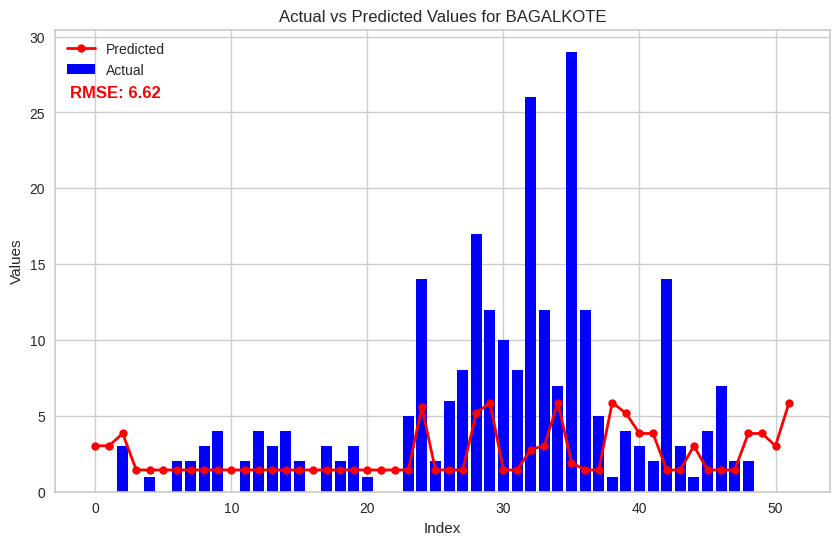

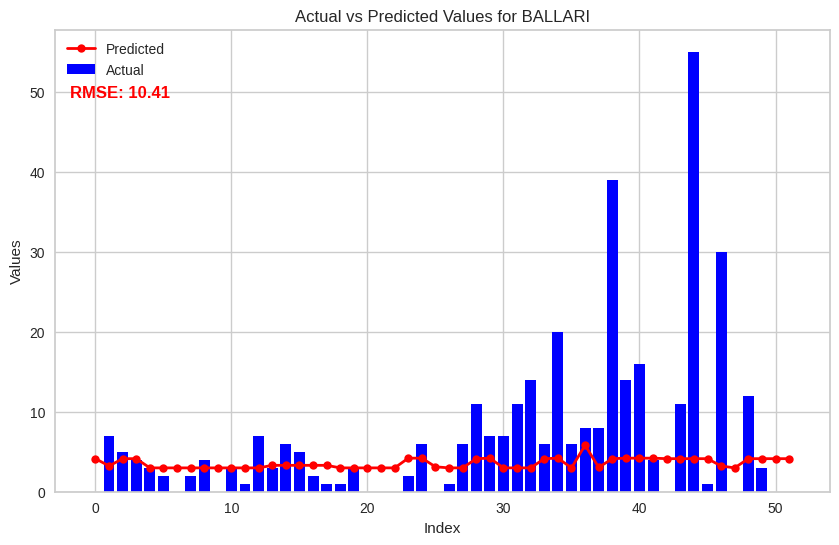

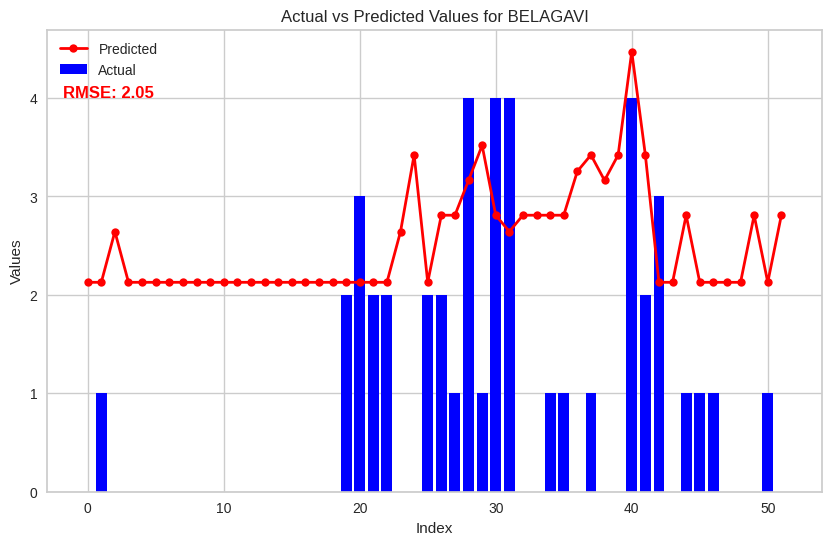

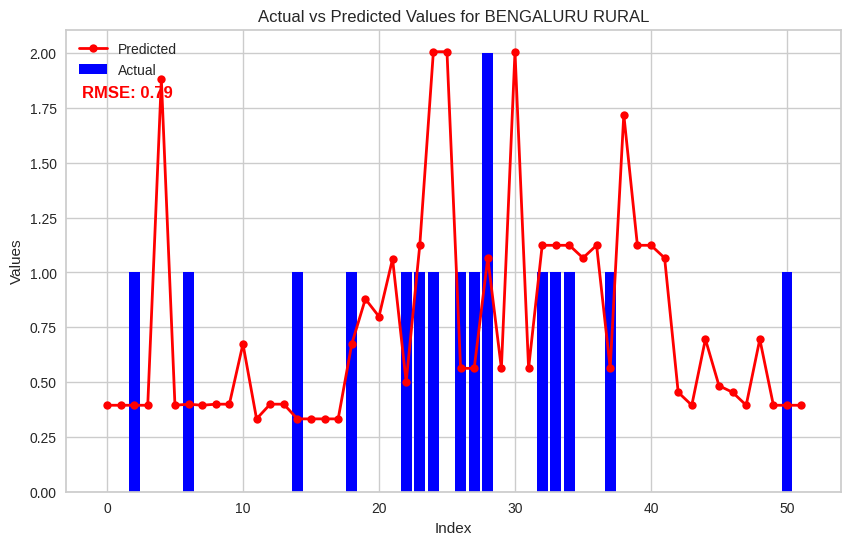

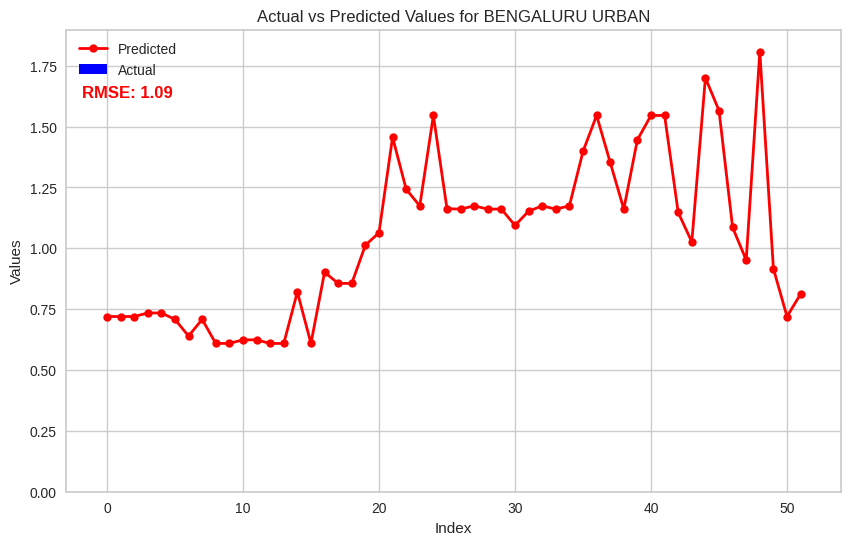

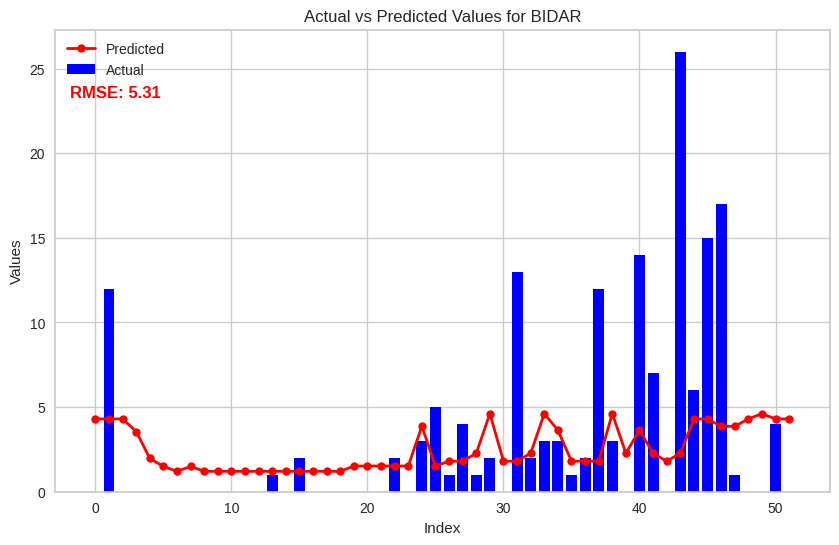

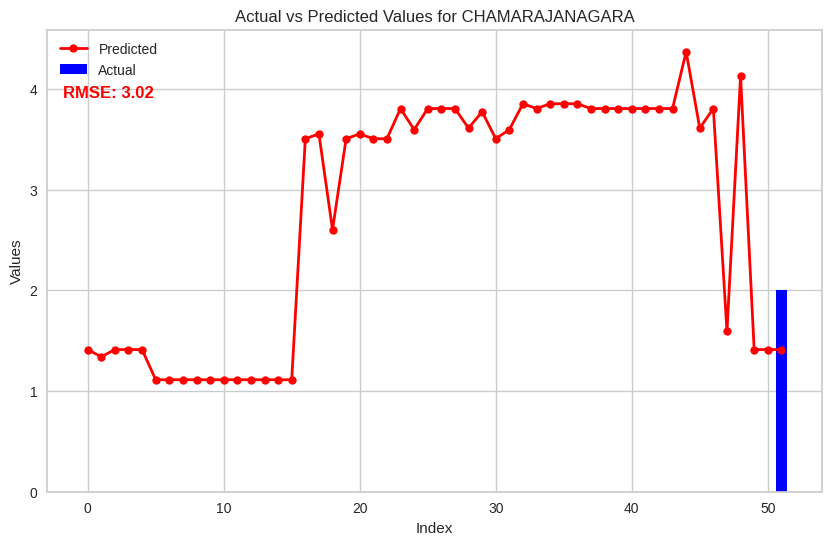

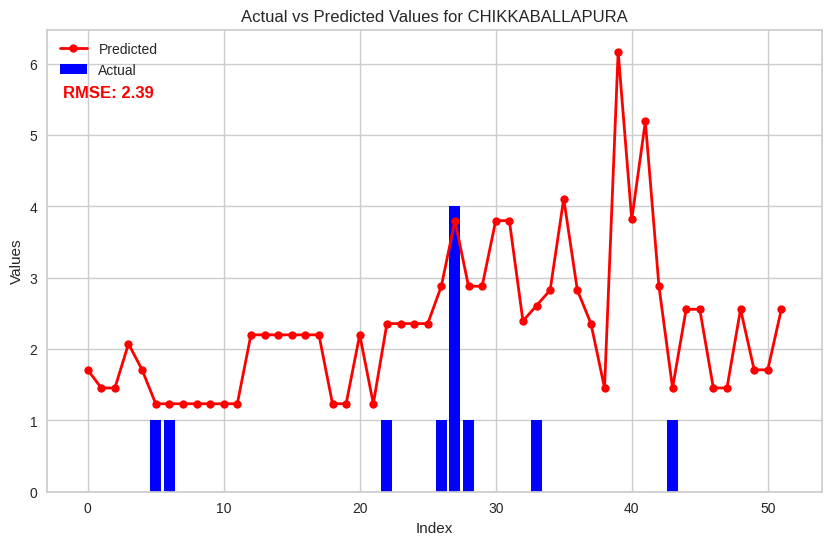

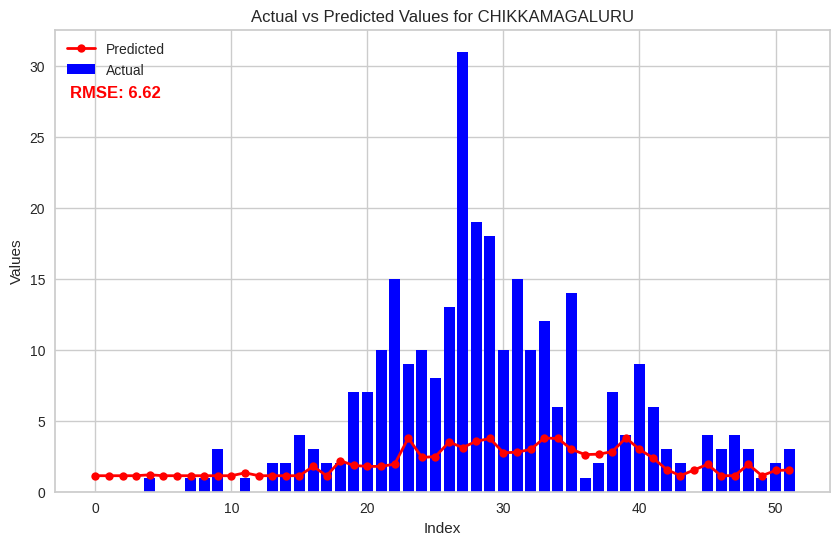

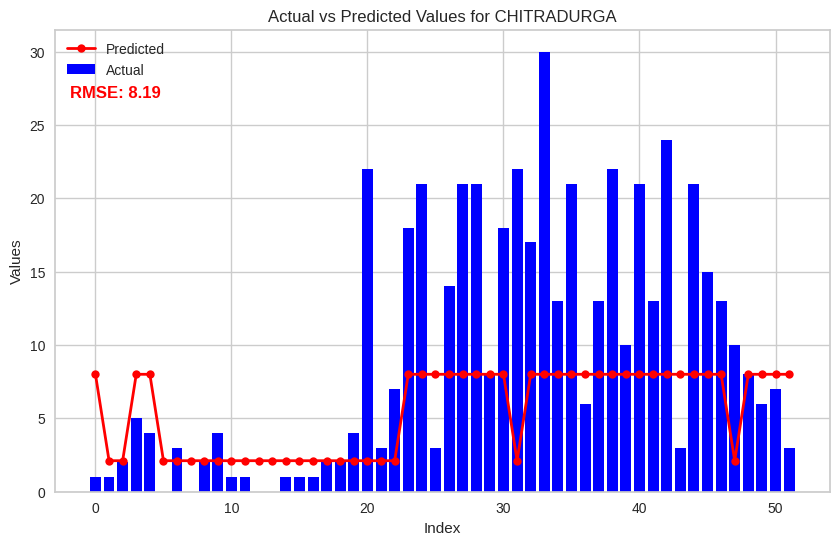

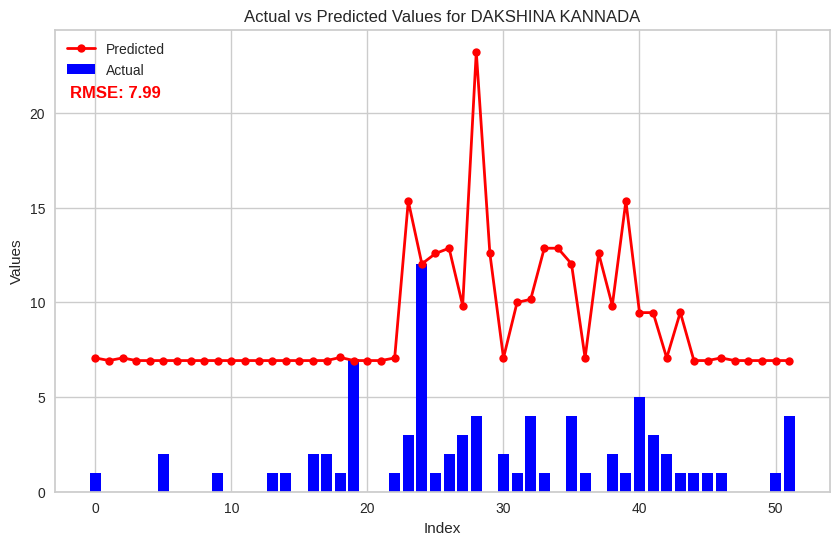

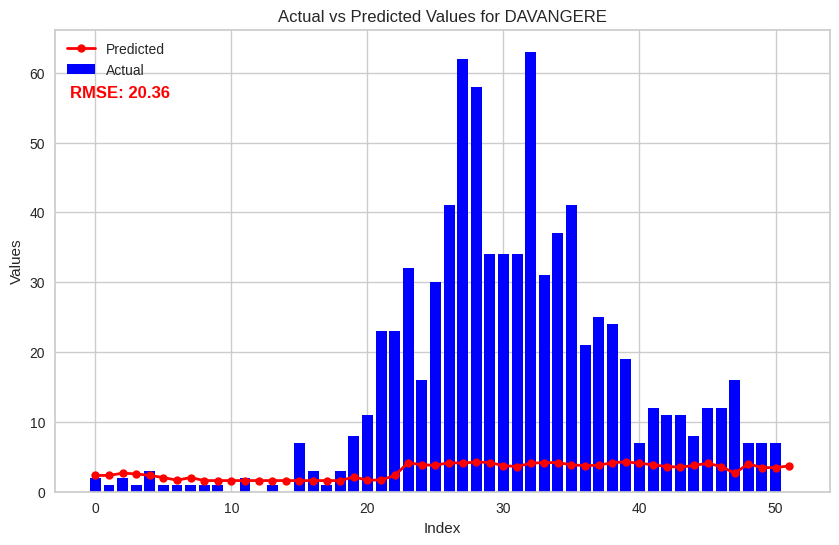

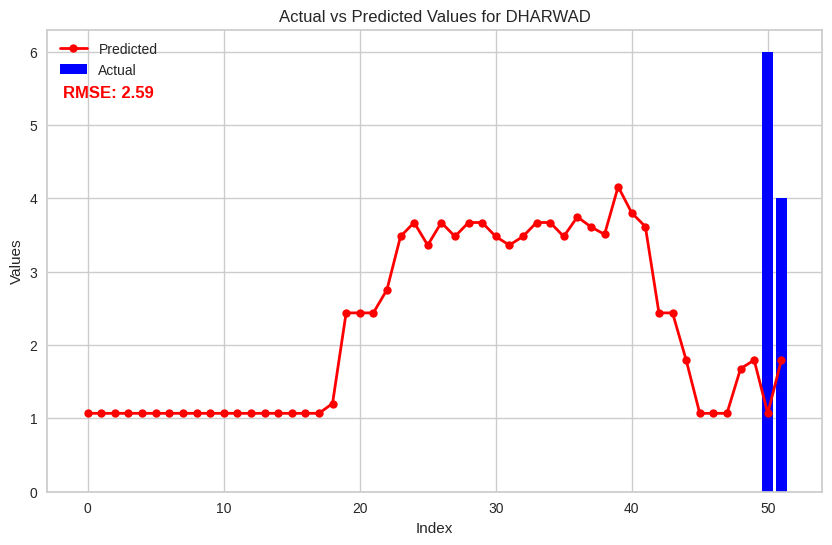

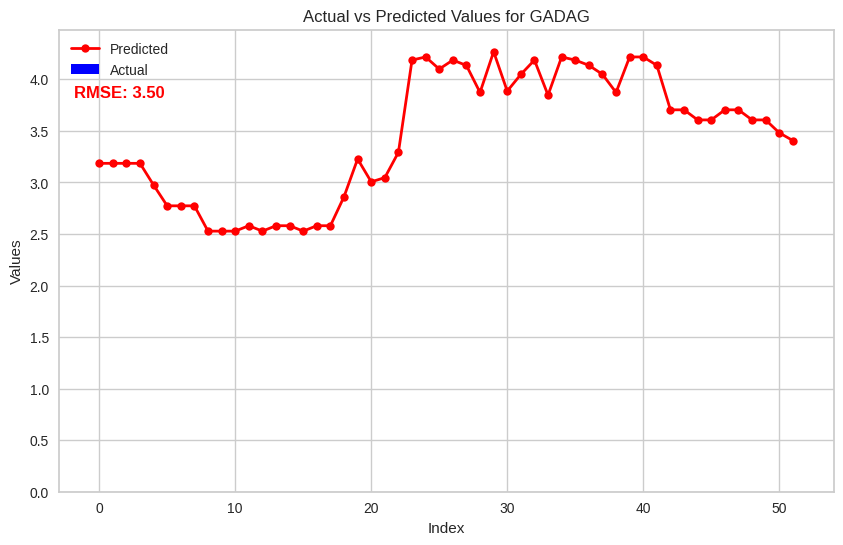

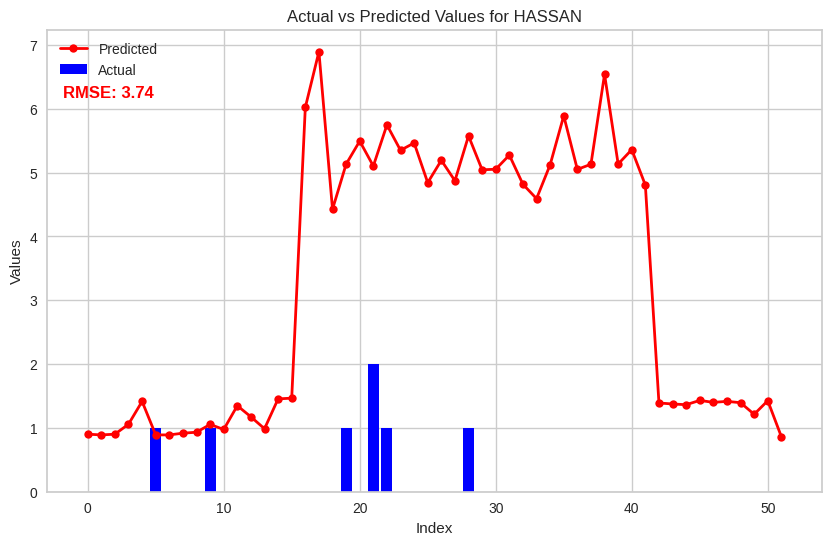

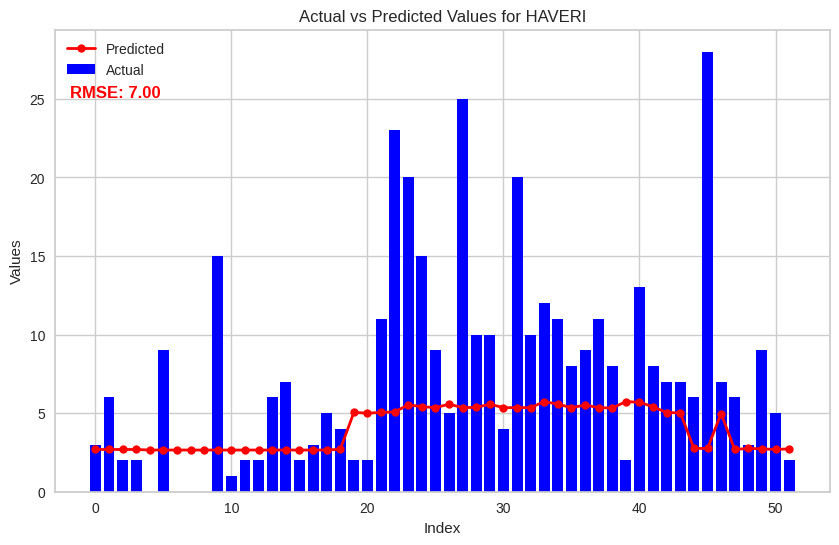

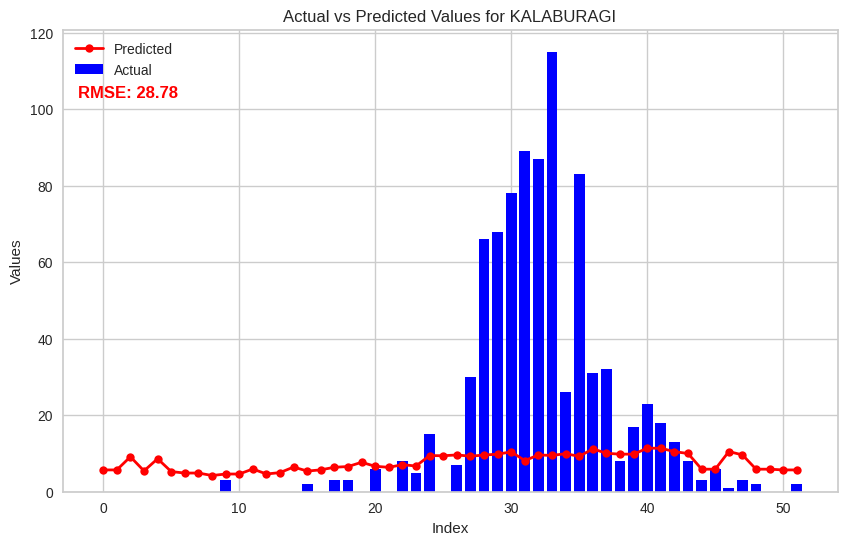

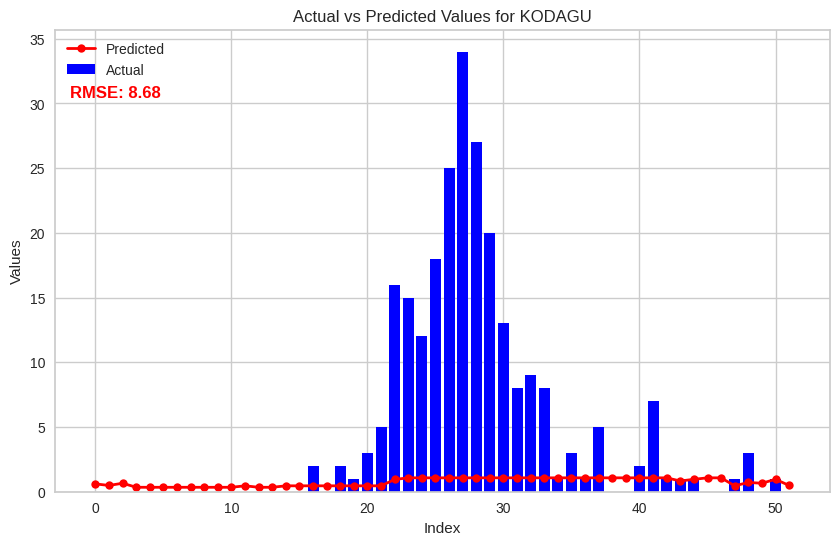

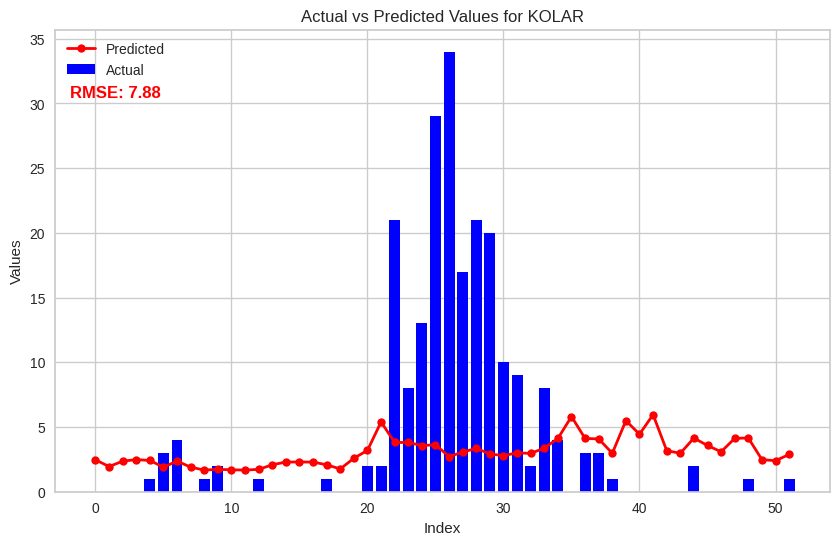

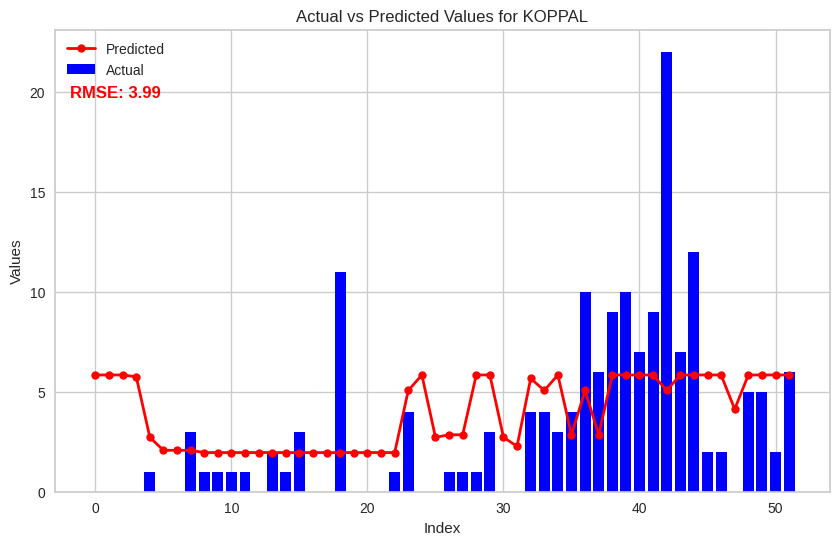

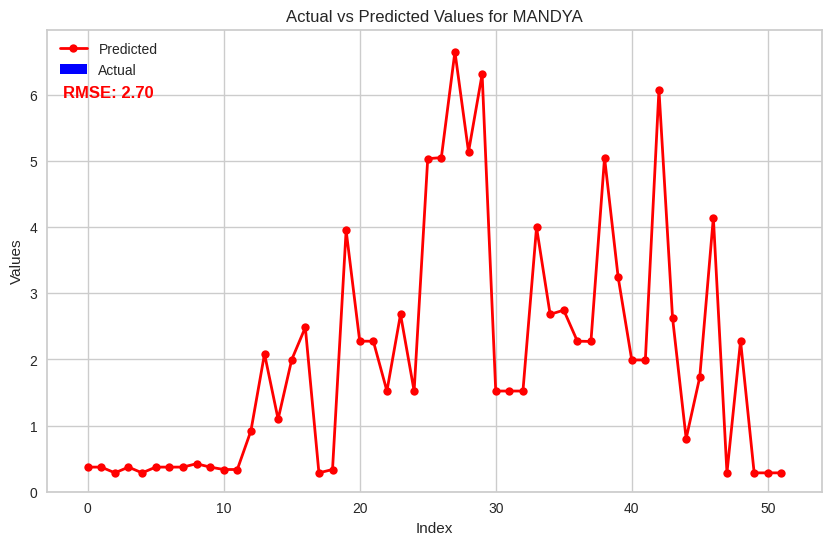

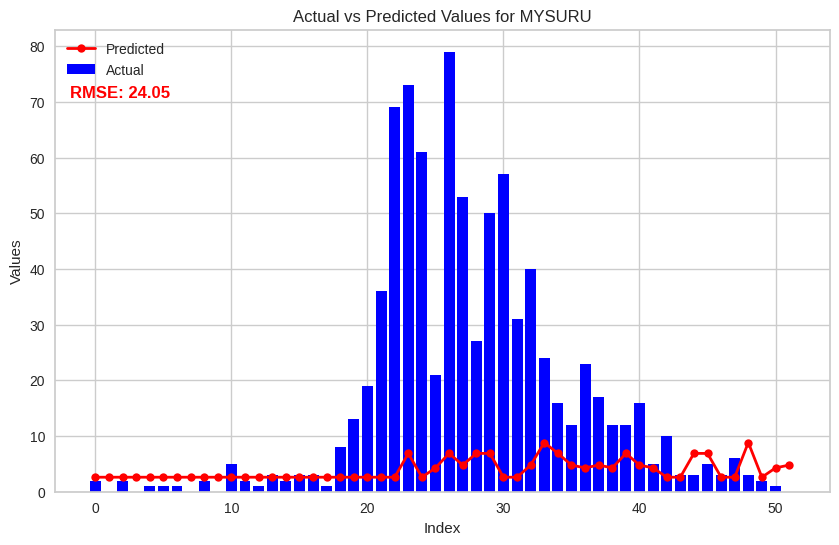

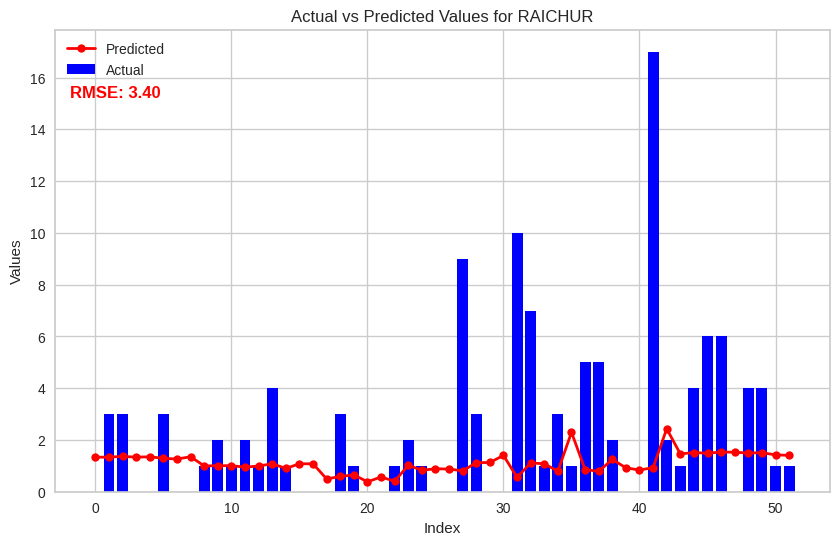

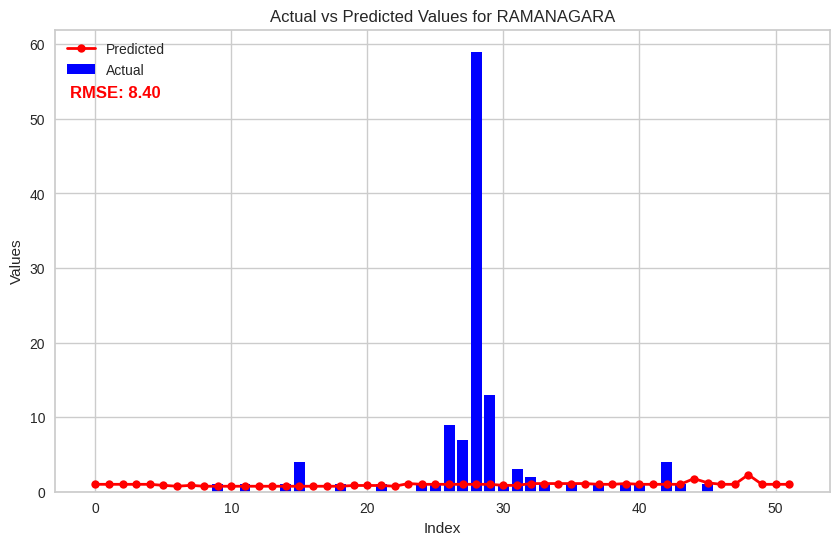

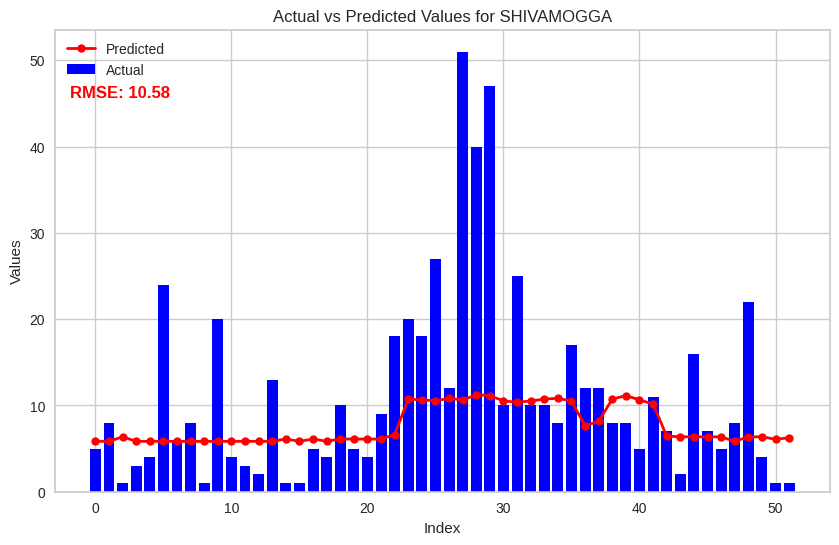

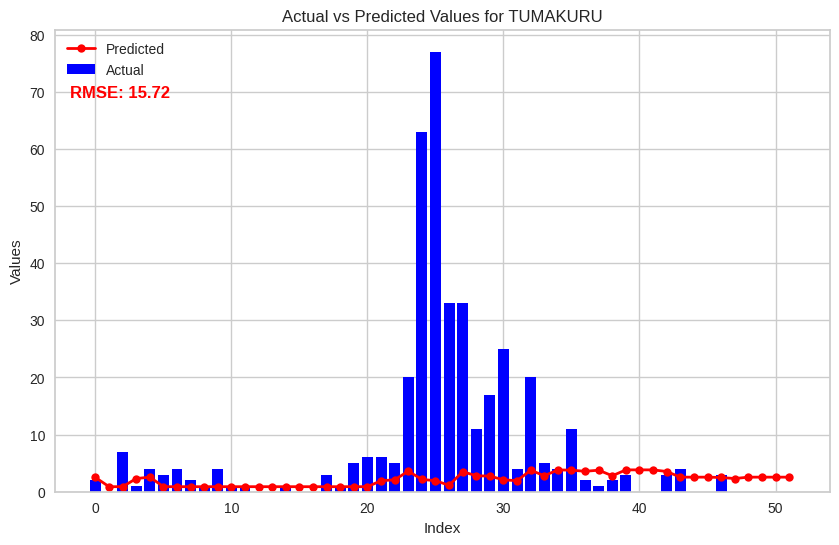

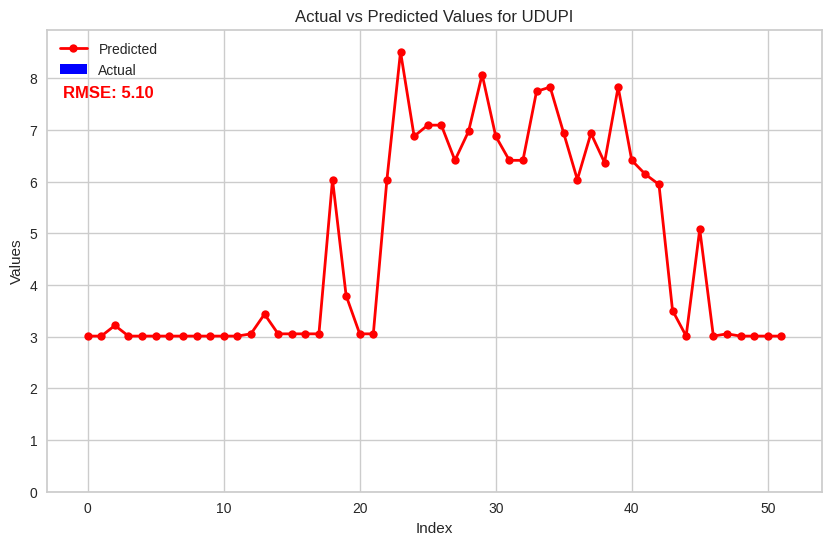

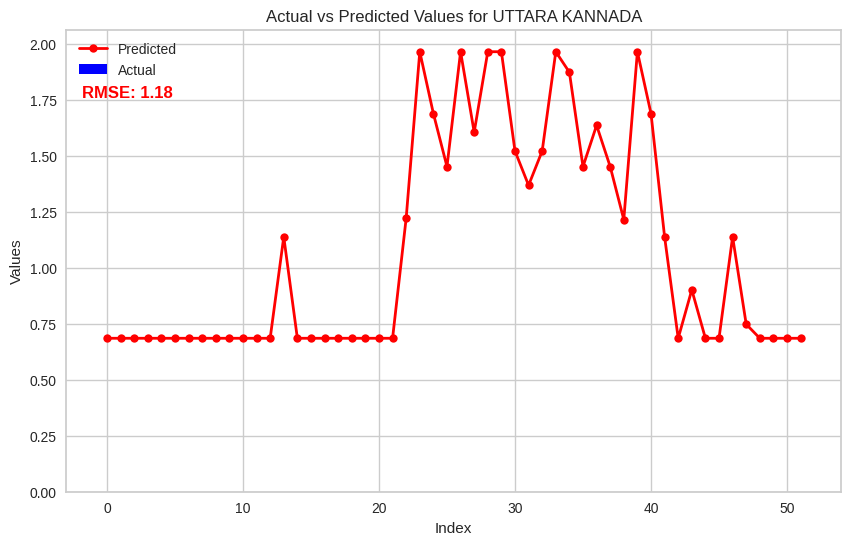

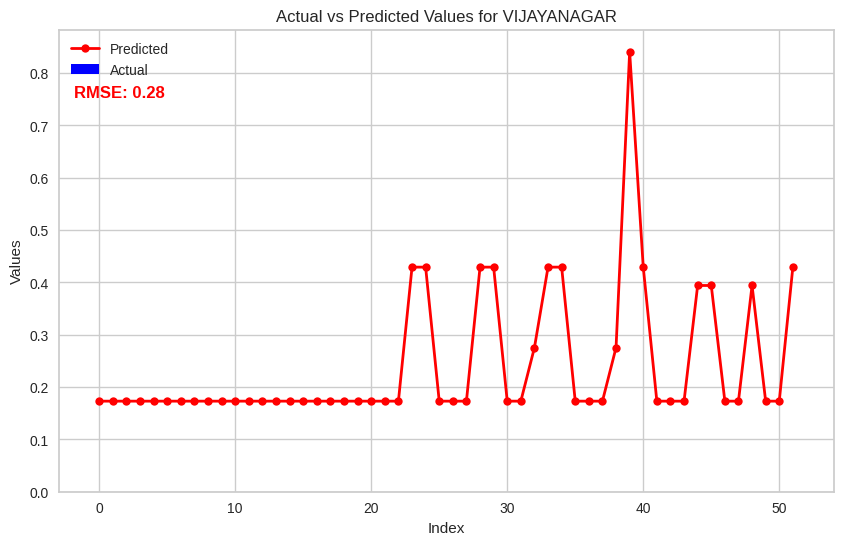

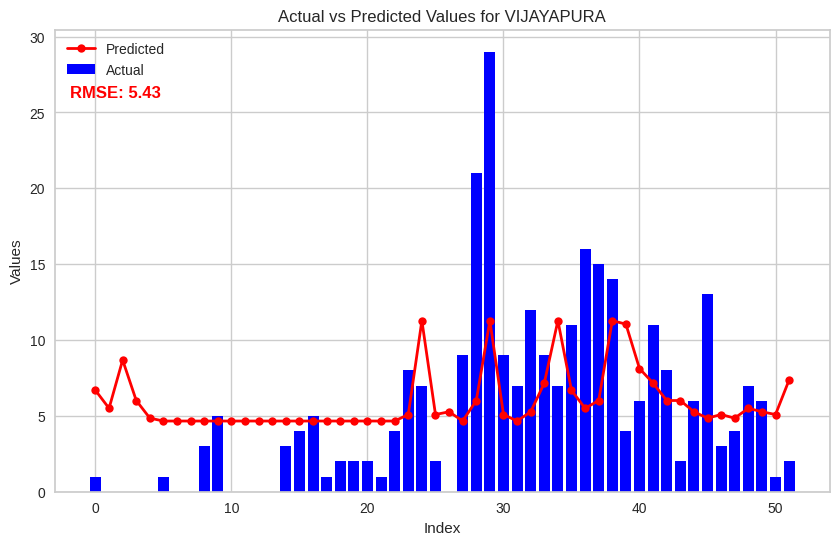

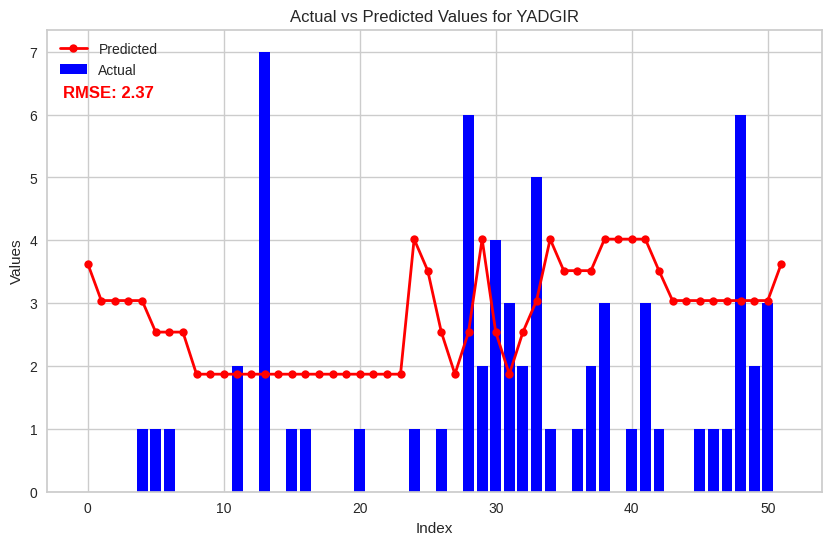

In [31]:
district_analysis = DistrictAnalysis("Karnataka_weather1980to2022.csv",2017)
df_2017 = district_analysis.analyze_districts()

In [32]:
df_2017

district  2017_rmse 2017_performance
0          BAGALKOTE   6.616716              Bad
1            BALLARI  10.411563              Bad
2           BELAGAVI   2.052069              Bad
3    BENGALURU RURAL   0.793686             Good
4    BENGALURU URBAN   1.092643             Good
5              BIDAR   5.307823              Bad
6    CHAMARAJANAGARA   3.018138              Bad
7    CHIKKABALLAPURA   2.388495              Bad
8     CHIKKAMAGALURU   6.624506              Bad
9        CHITRADURGA   8.188596              Bad
10  DAKSHINA KANNADA   7.992087              Bad
11         DAVANGERE  20.362137              Bad
12           DHARWAD   2.592432              Bad
13             GADAG   3.498164              Bad
14            HASSAN   3.743206              Bad
15            HAVERI   6.997480              Bad
16        KALABURAGI  28.780813              Bad
17            KODAGU   8.677875              Bad
18             KOLAR   7.878676              Bad
19            KOPPAL   3.989389              Bad
20            MANDYA   2.701954              Bad
21            MYSURU  24.045005              Bad
22           RAICHUR   3.400755              Bad
23        RAMANAGARA   8.396047              Bad
24        SHIVAMOGGA  10.580864              Bad
25          TUMAKURU  15.717036              Bad
26             UDUPI   5.095411              Bad
27    UTTARA KANNADA   1.176597             Good
28       VIJAYANAGAR   0.275199             Good
29        VIJAYAPURA   5.427360              Bad
30            YADGIR   2.370097              Bad

Analyzing District: BAGALKOTE
Analyzing District: BALLARI
Analyzing District: BELAGAVI
Analyzing District: BENGALURU RURAL
Analyzing District: BENGALURU URBAN
Analyzing District: BIDAR
Analyzing District: CHAMARAJANAGARA
Analyzing District: CHIKKABALLAPURA
Analyzing District: CHIKKAMAGALURU
Analyzing District: CHITRADURGA
Analyzing District: DAKSHINA KANNADA
Analyzing District: DAVANGERE
Analyzing District: DHARWAD
Analyzing District: GADAG
Analyzing District: HASSAN
Analyzing District: HAVERI
Analyzing District: KALABURAGI
Analyzing District: KODAGU
Analyzing District: KOLAR
Analyzing District: KOPPAL
Analyzing District: MANDYA
Analyzing District: MYSURU
Analyzing District: RAICHUR
Analyzing District: RAMANAGARA
Analyzing District: SHIVAMOGGA
Analyzing District: TUMAKURU
Analyzing District: UDUPI
Analyzing District: UTTARA KANNADA
Analyzing District: VIJAYANAGAR
Analyzing District: VIJAYAPURA
Analyzing District: YADGIR


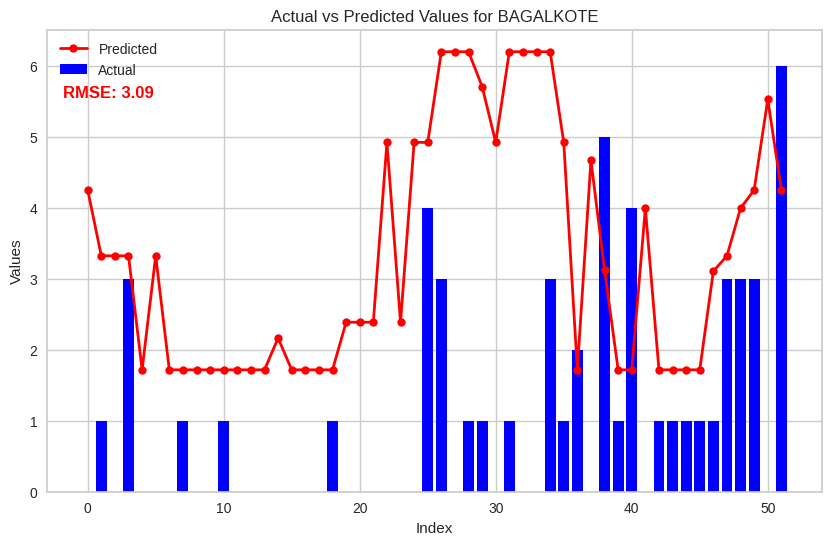

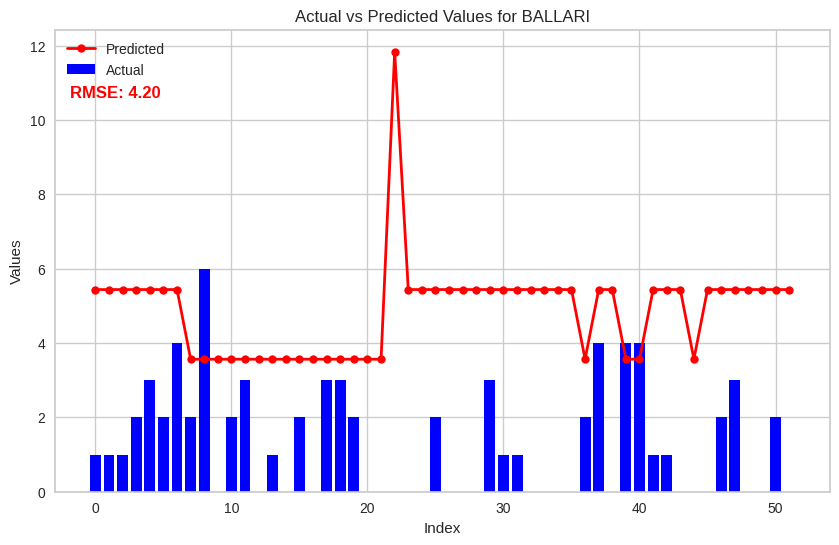

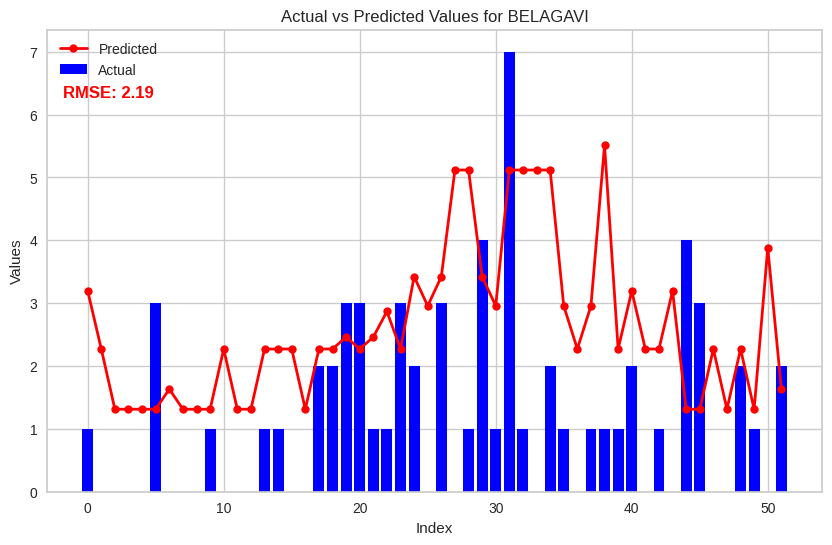

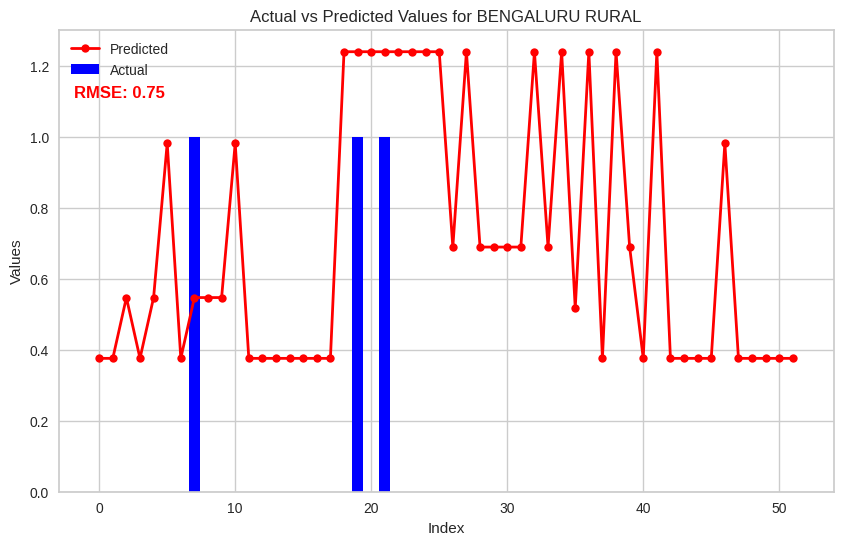

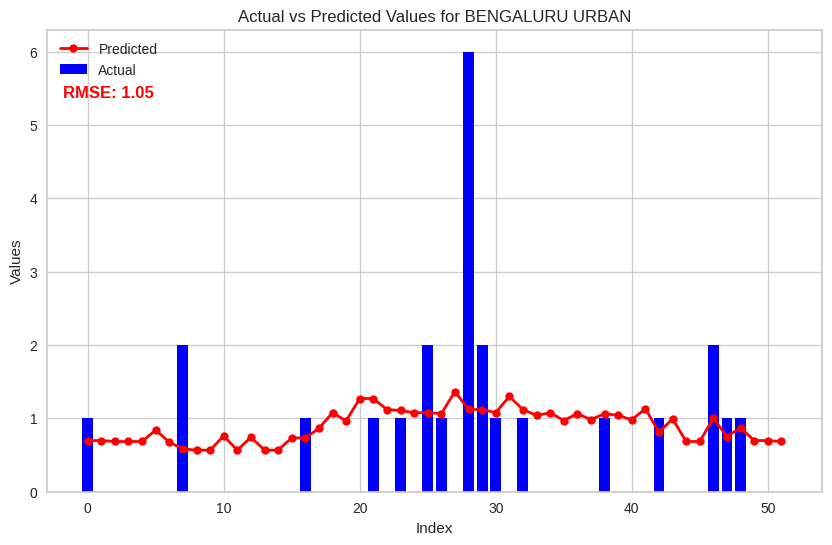

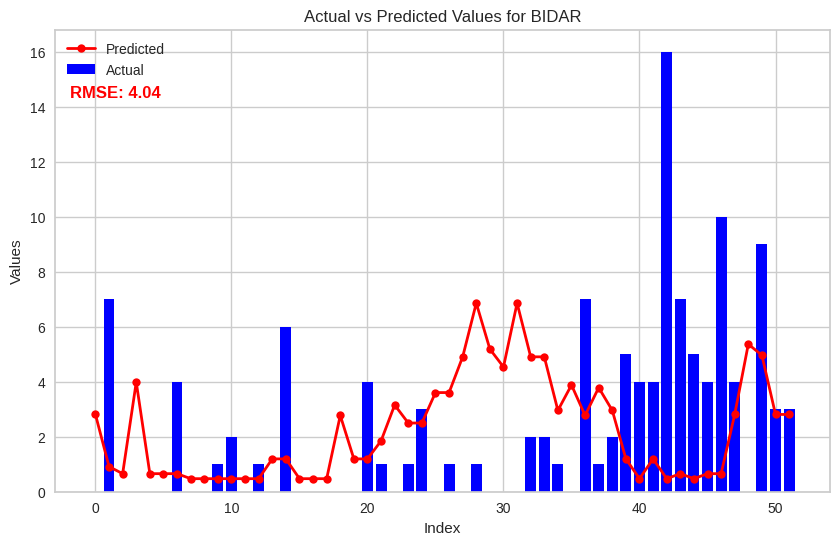

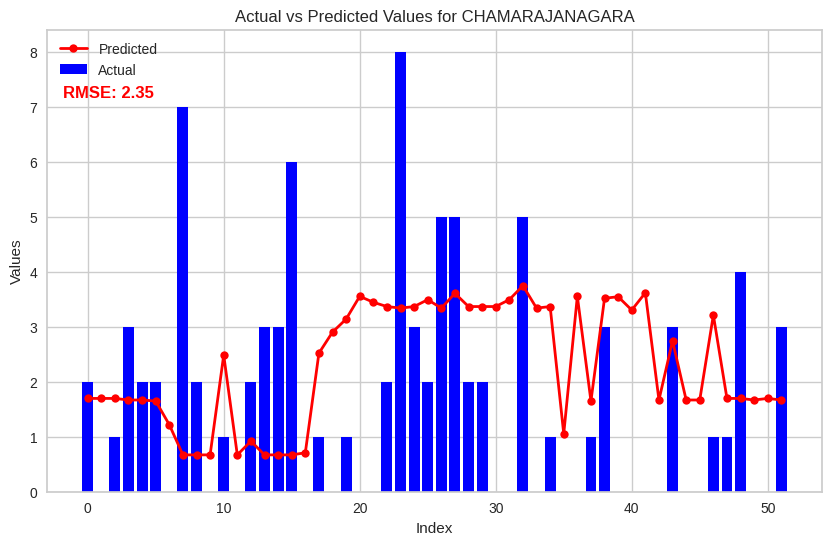

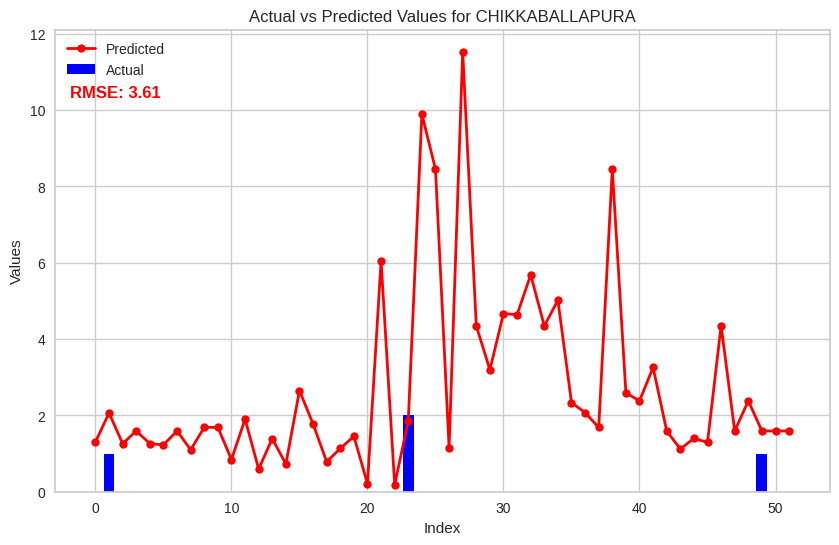

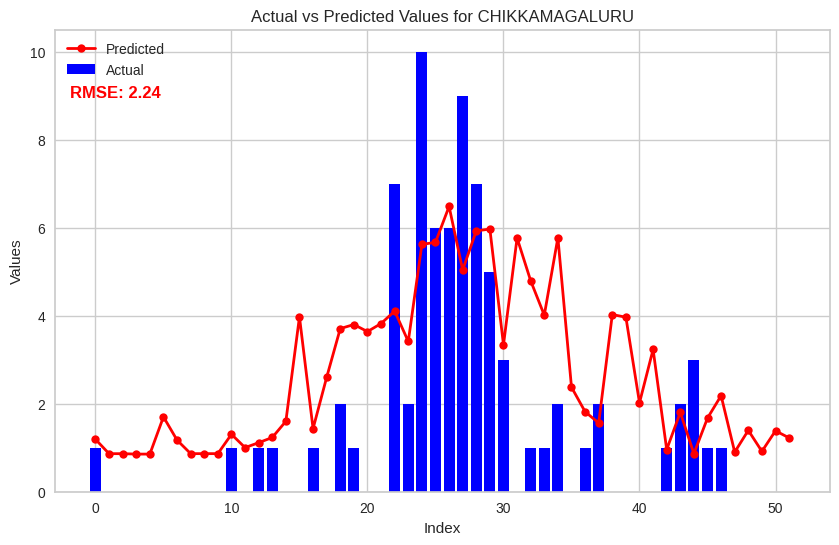

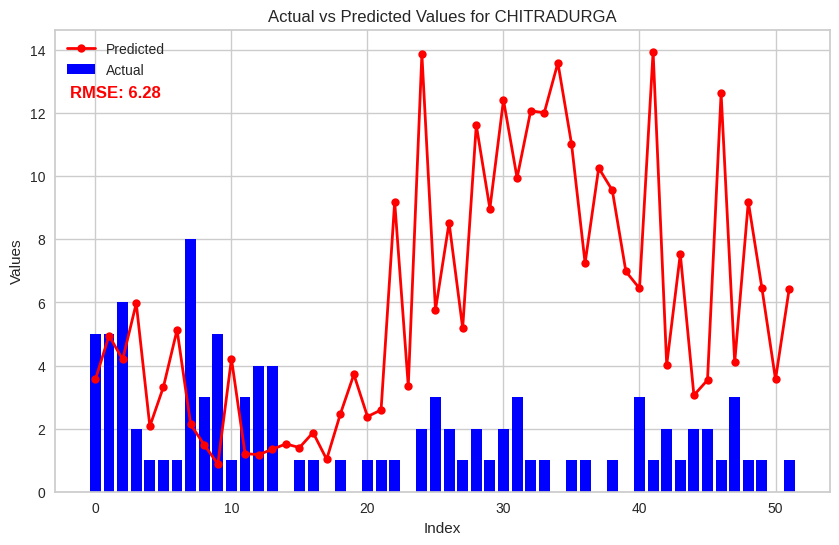

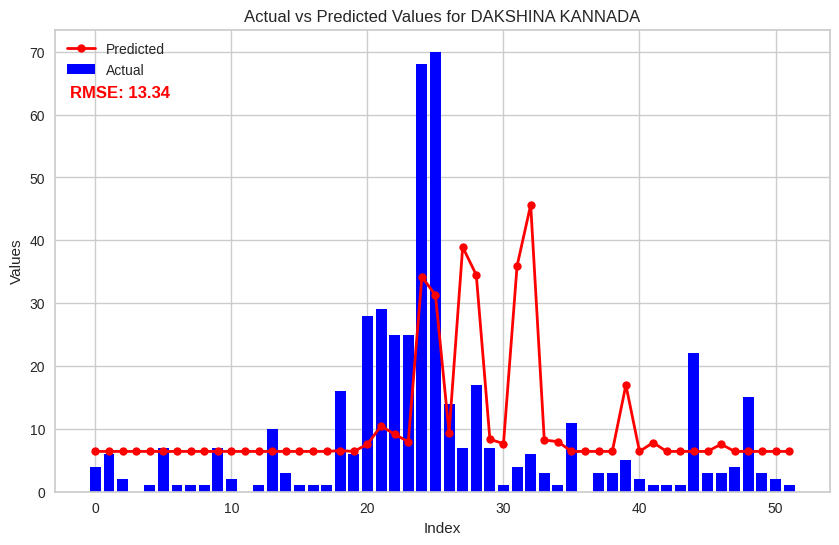

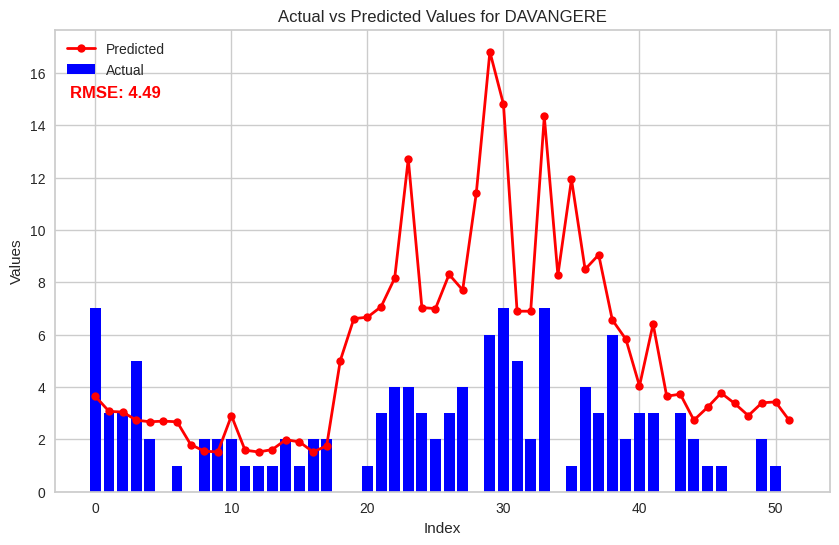

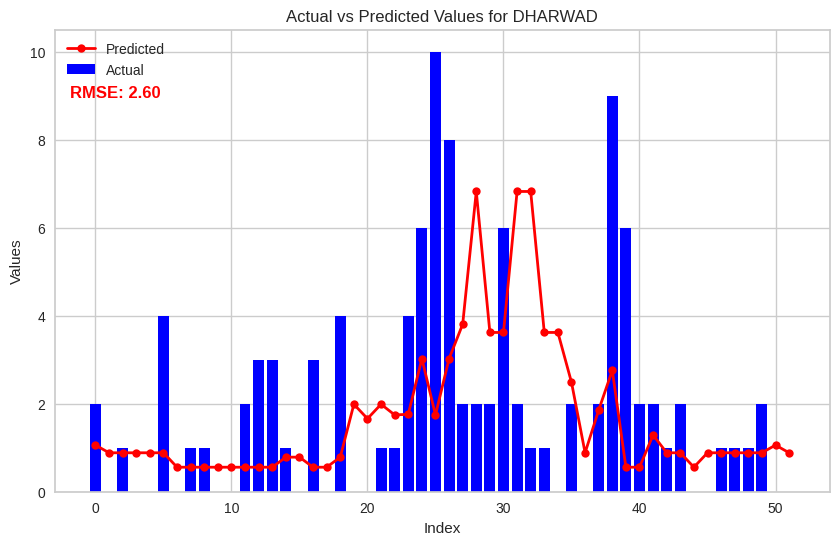

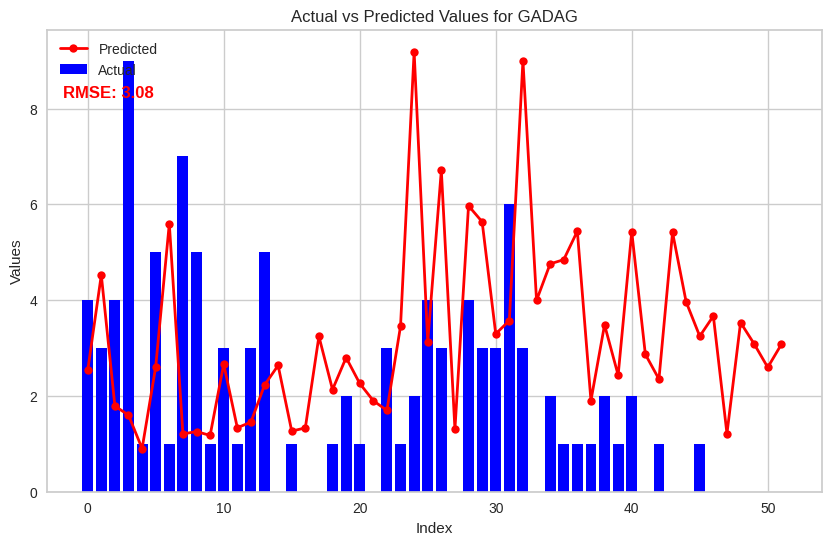

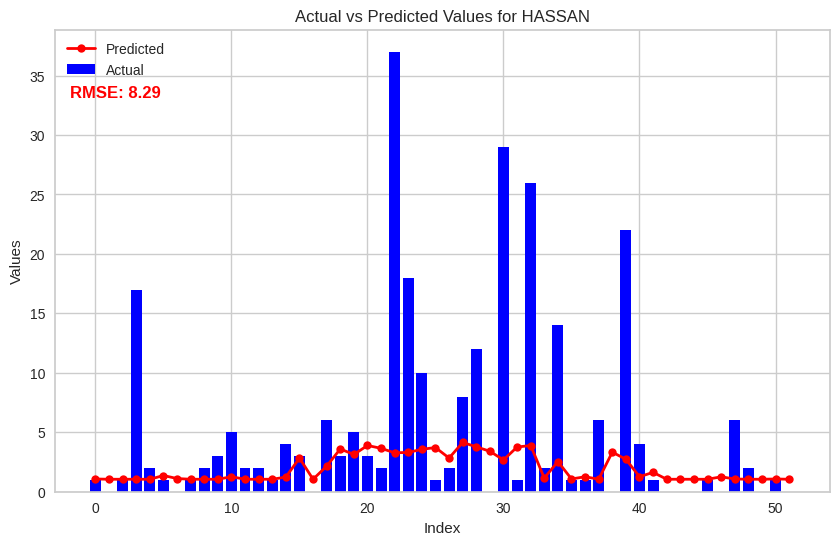

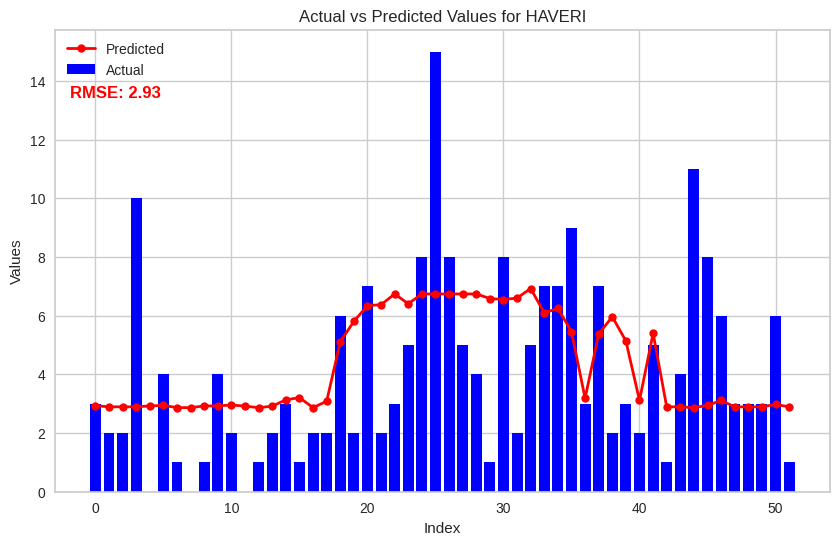

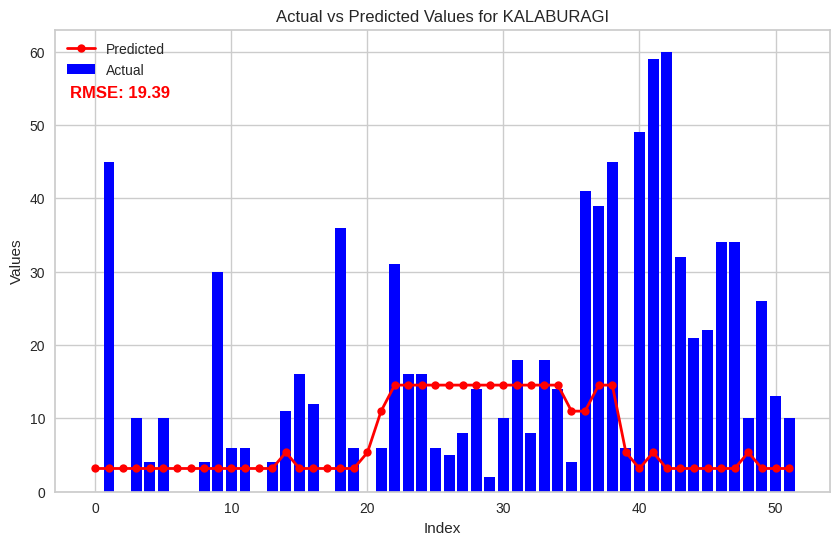

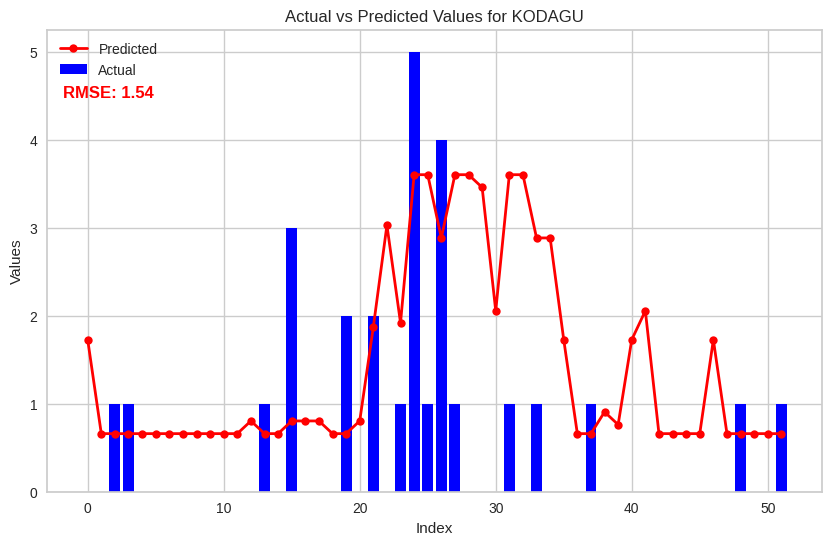

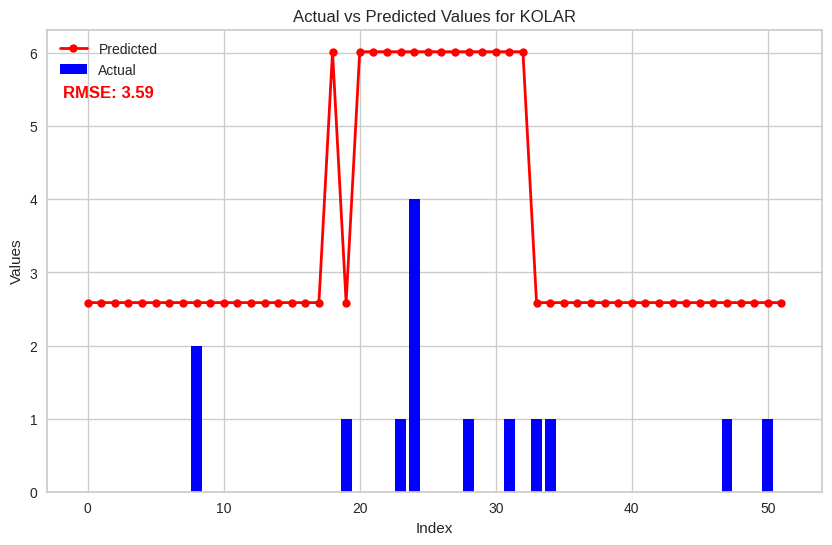

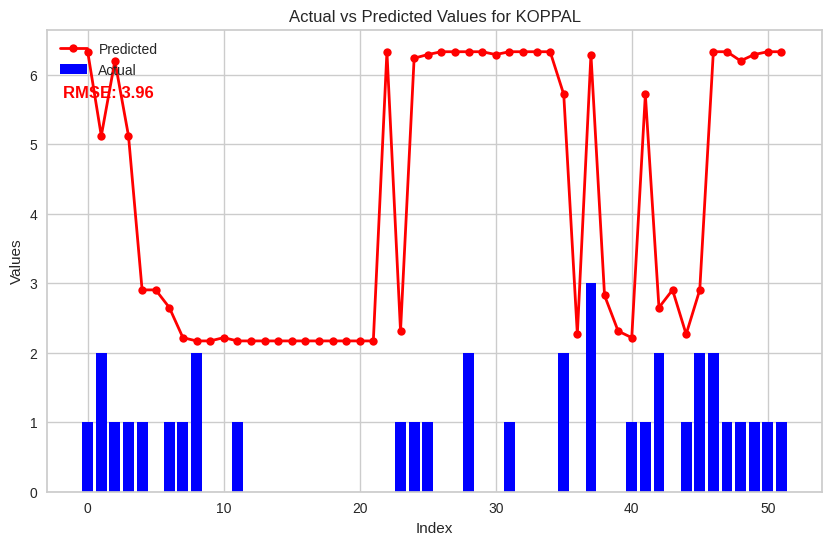

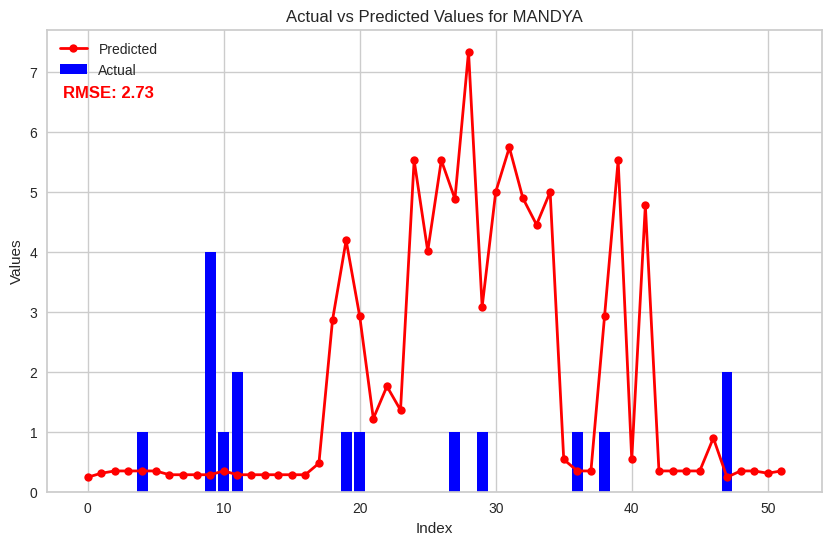

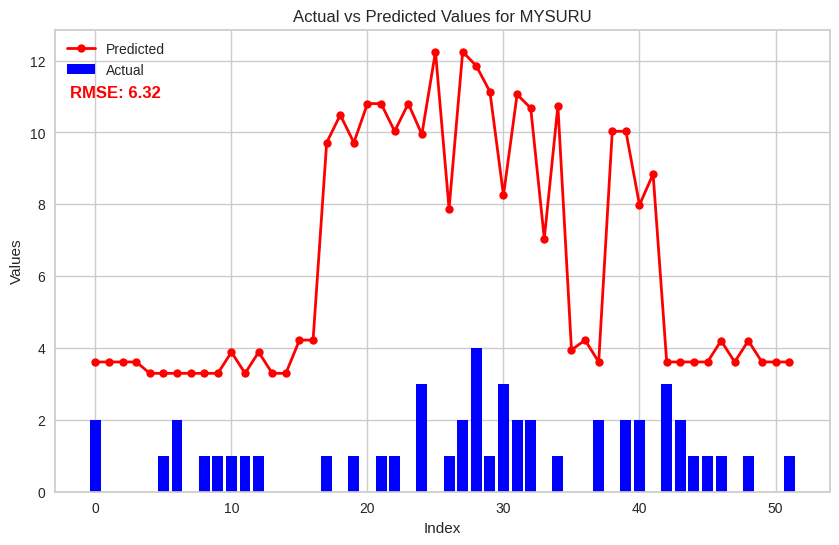

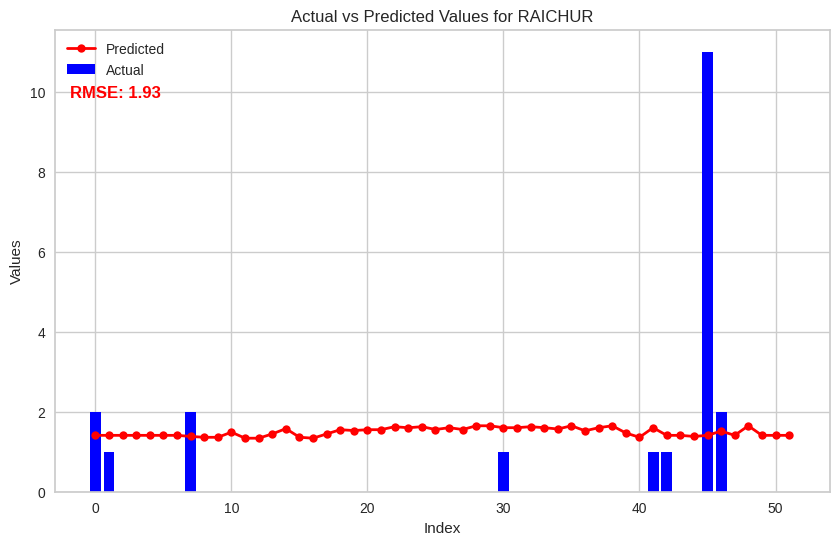

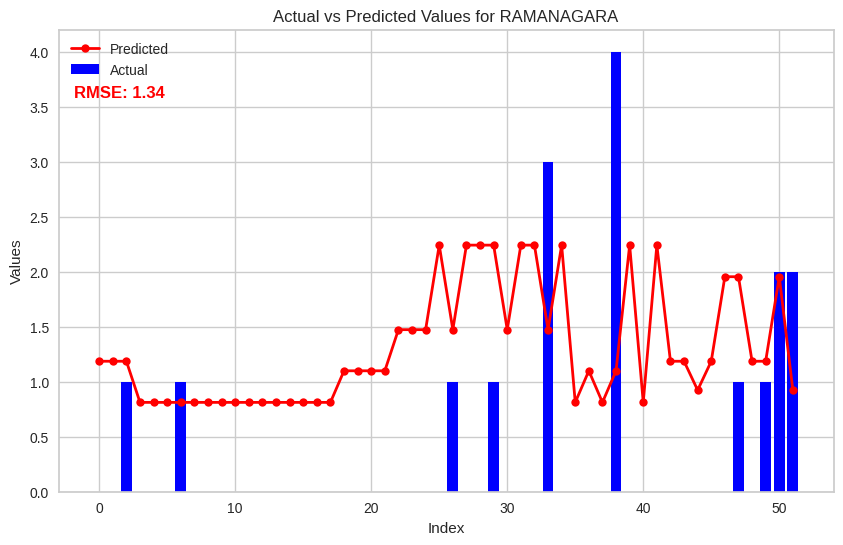

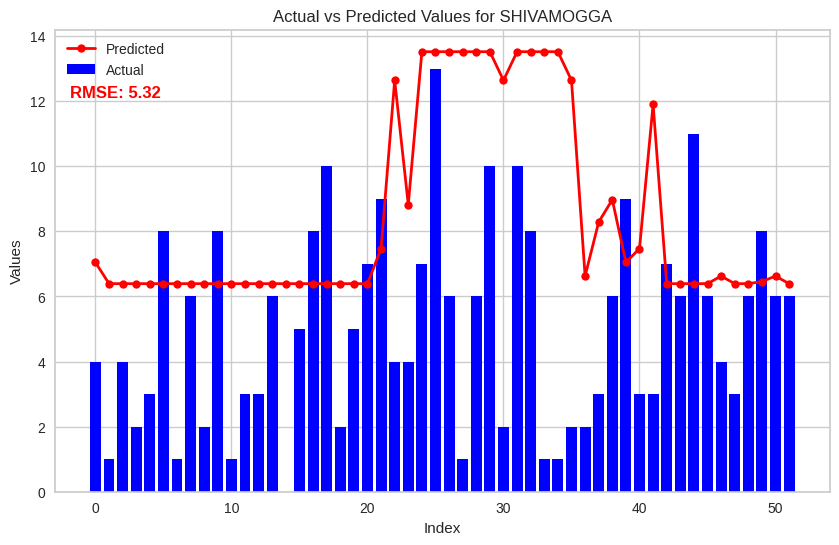

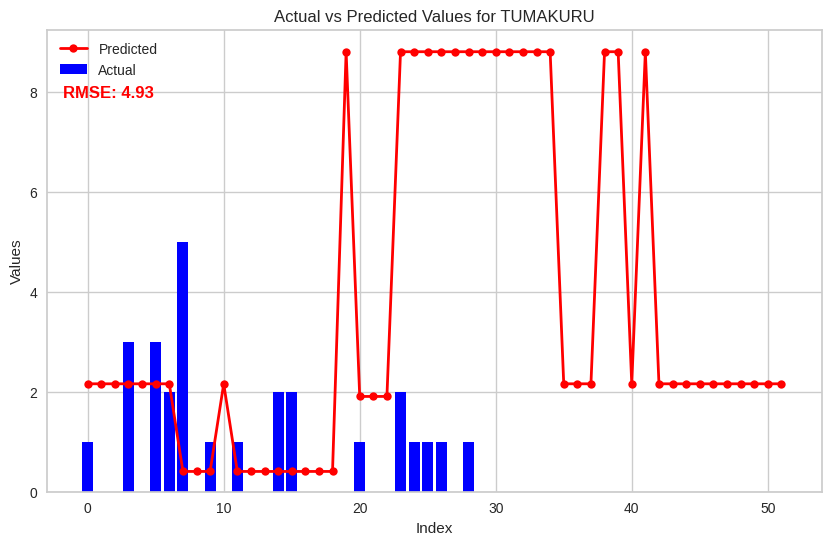

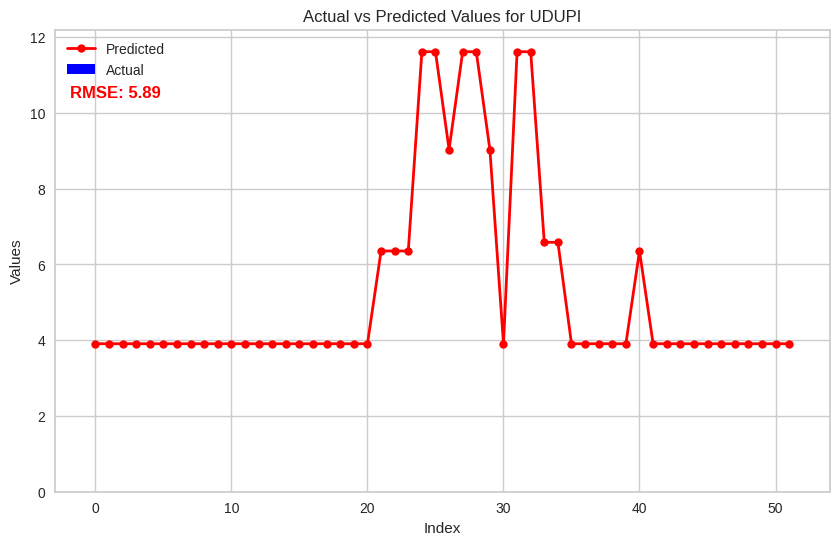

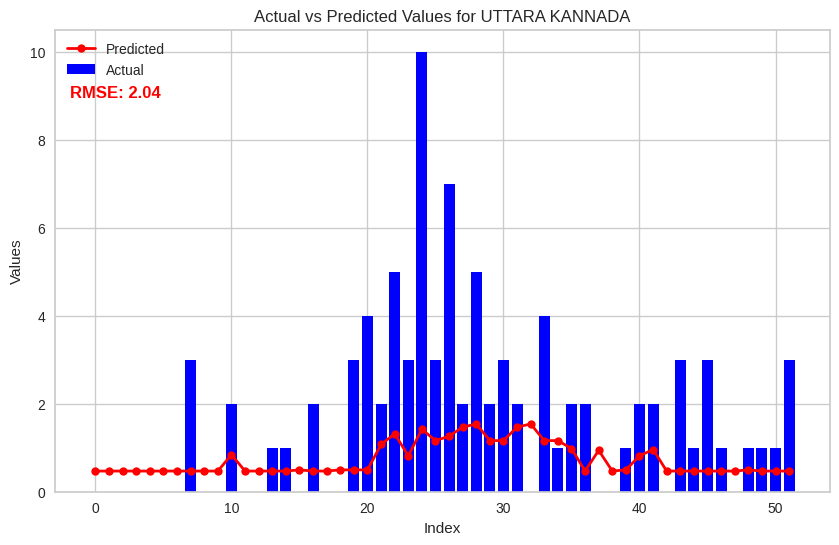

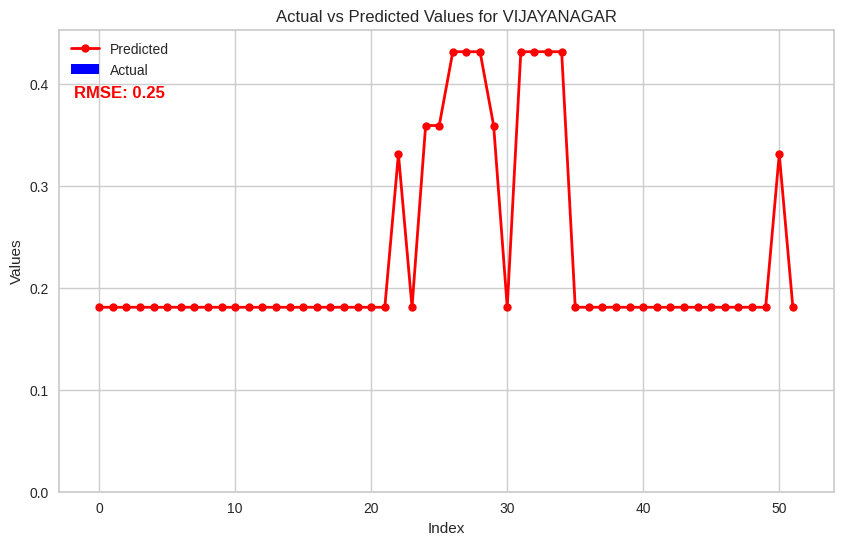

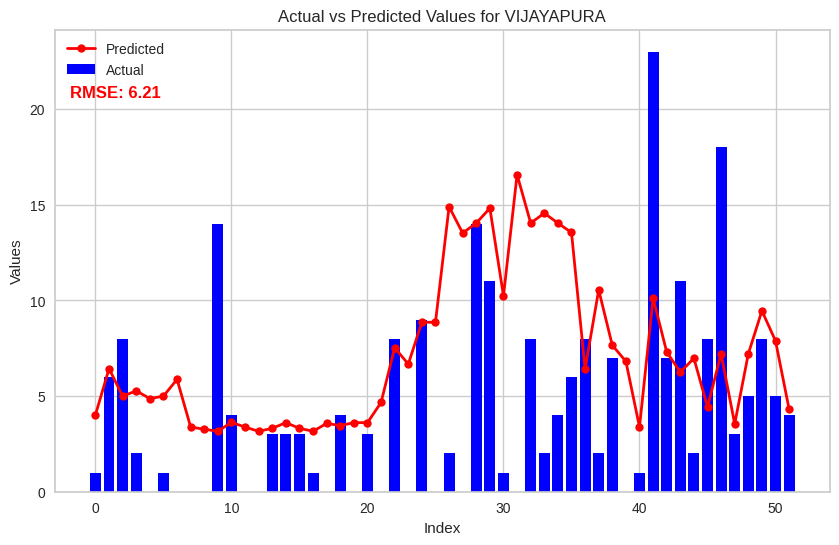

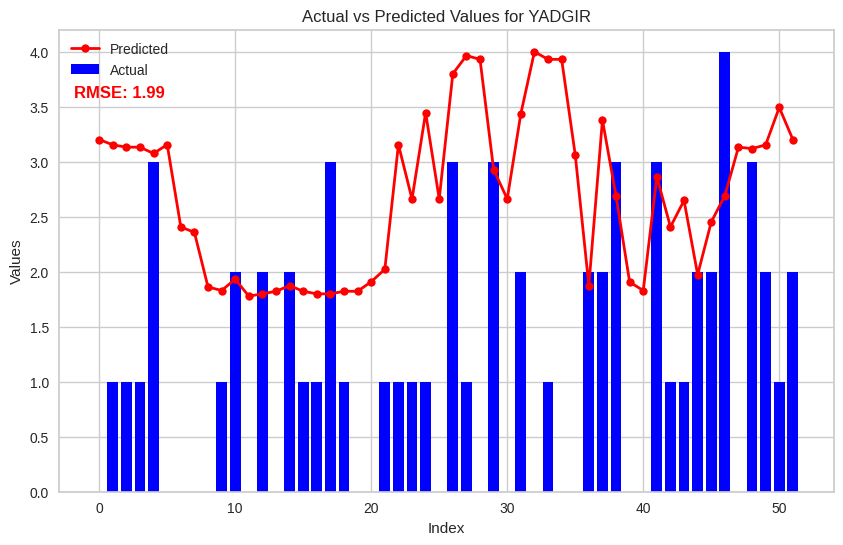

In [33]:
district_analysis = DistrictAnalysis("Karnataka_weather1980to2022.csv",2018)
df_2018 = district_analysis.analyze_districts()

Analyzing District: BAGALKOTE
Analyzing District: BALLARI
Analyzing District: BELAGAVI
Analyzing District: BENGALURU RURAL
Analyzing District: BENGALURU URBAN
Analyzing District: BIDAR
Analyzing District: CHAMARAJANAGARA
Analyzing District: CHIKKABALLAPURA
Analyzing District: CHIKKAMAGALURU
Analyzing District: CHITRADURGA
Analyzing District: DAKSHINA KANNADA
Analyzing District: DAVANGERE
Analyzing District: DHARWAD
Analyzing District: GADAG
Analyzing District: HASSAN
Analyzing District: HAVERI
Analyzing District: KALABURAGI
Analyzing District: KODAGU
Analyzing District: KOLAR
Analyzing District: KOPPAL
Analyzing District: MANDYA
Analyzing District: MYSURU
Analyzing District: RAICHUR
Analyzing District: RAMANAGARA
Analyzing District: SHIVAMOGGA
Analyzing District: TUMAKURU
Analyzing District: UDUPI
Analyzing District: UTTARA KANNADA
Analyzing District: VIJAYANAGAR
Analyzing District: VIJAYAPURA
Analyzing District: YADGIR


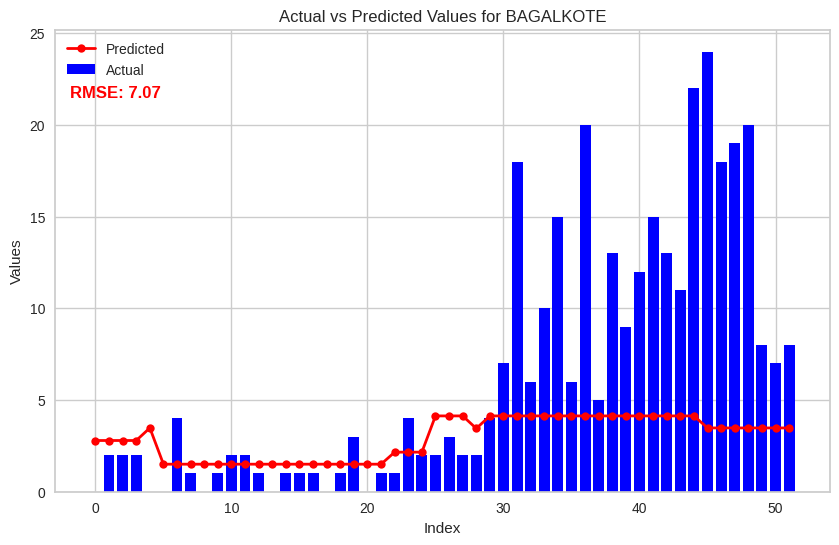

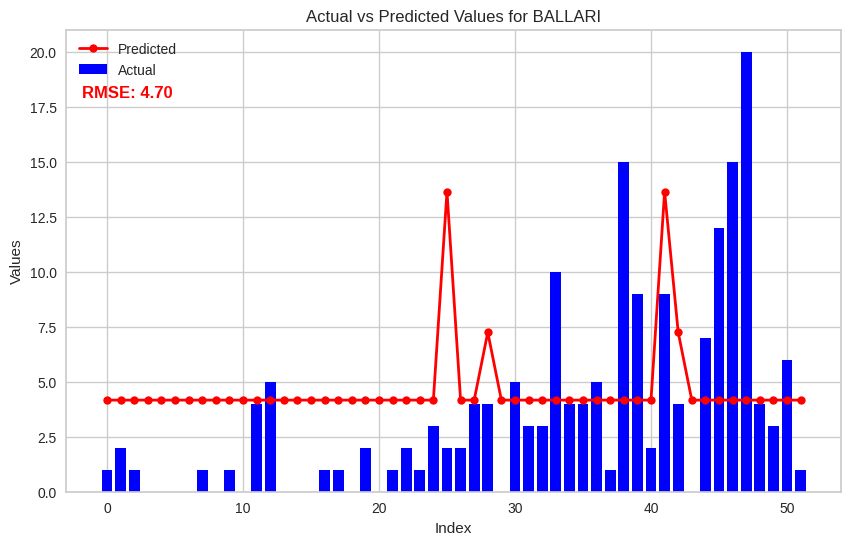

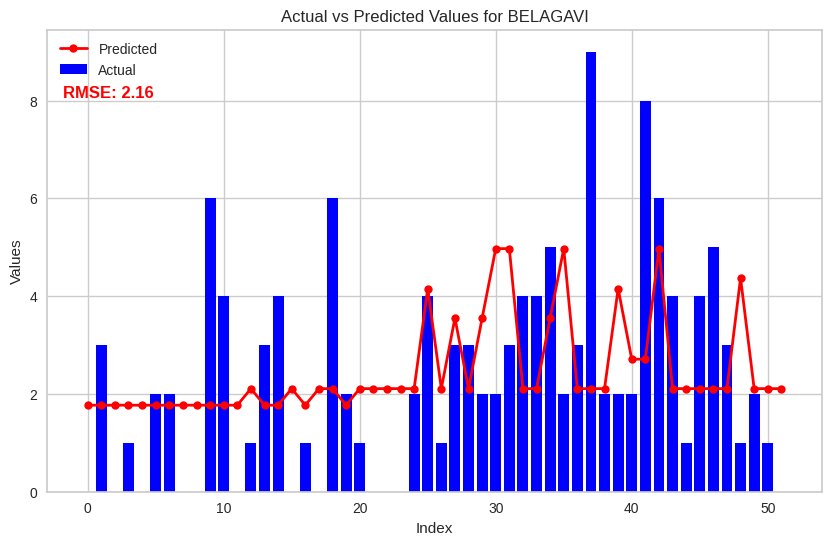

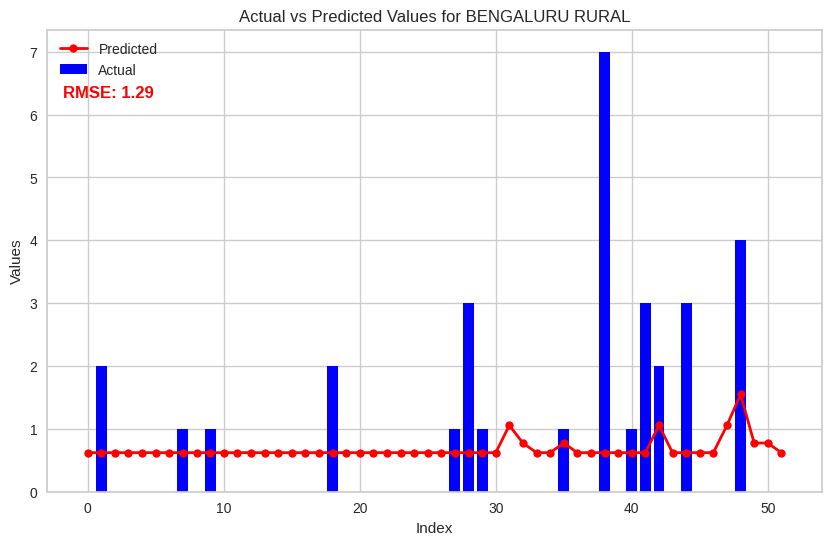

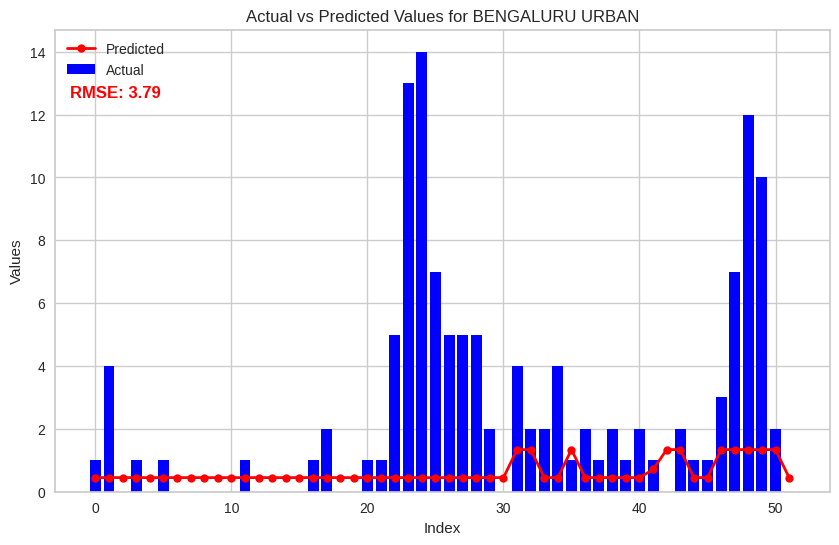

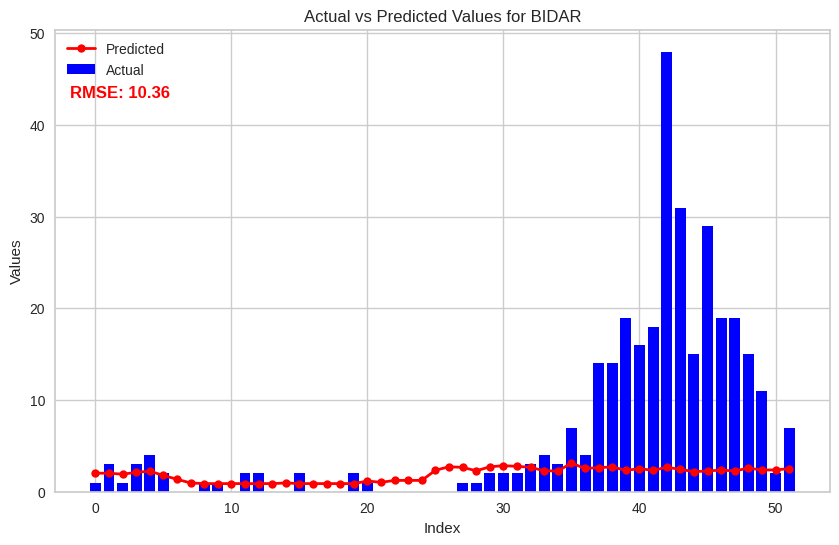

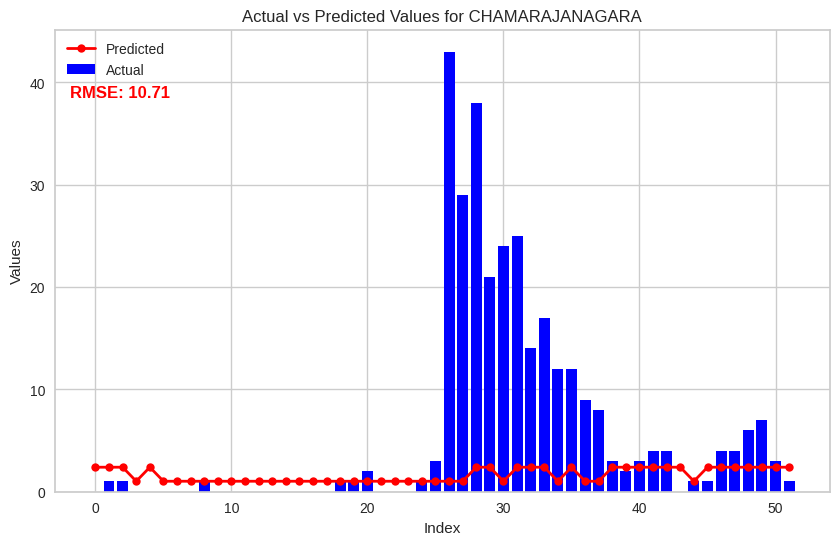

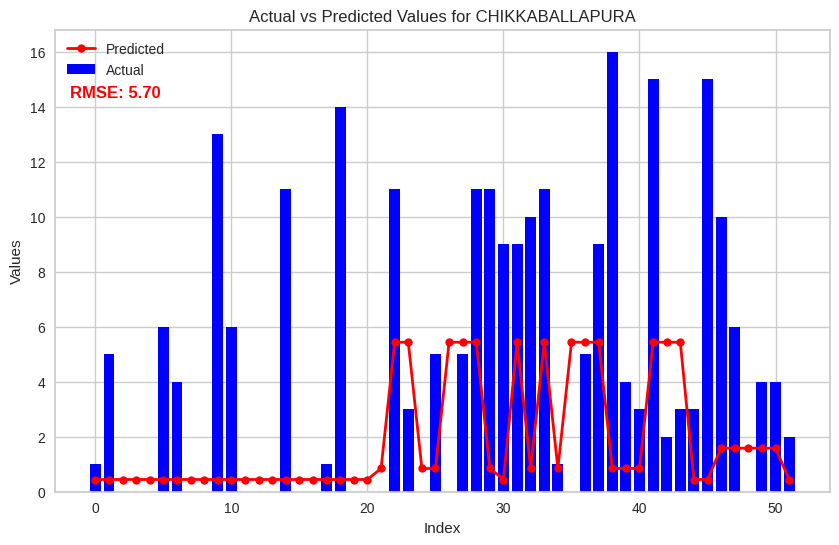

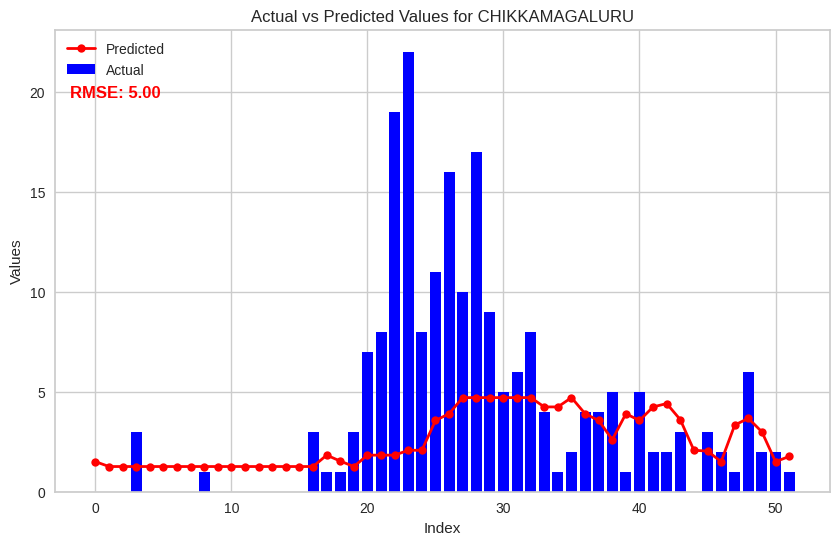

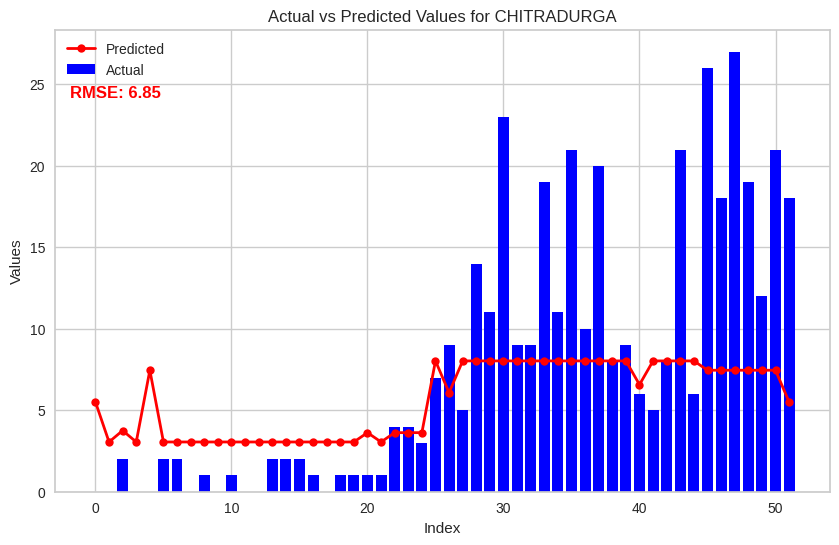

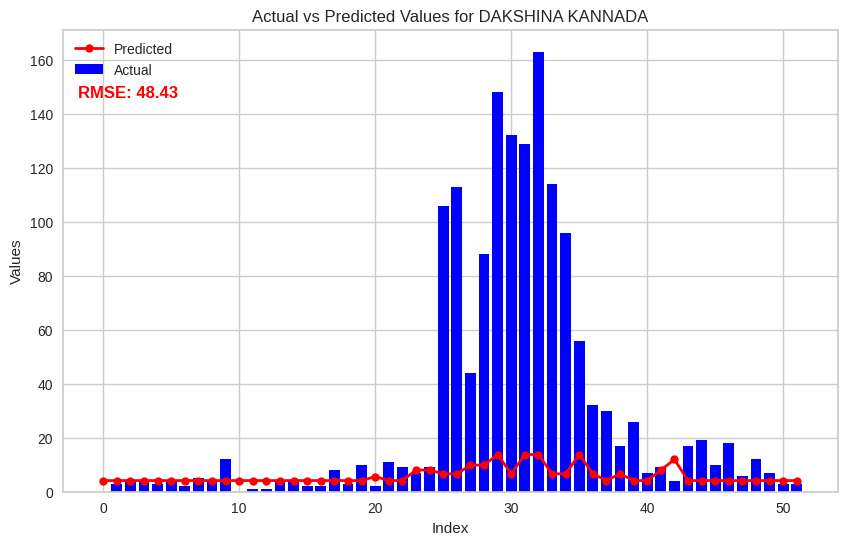

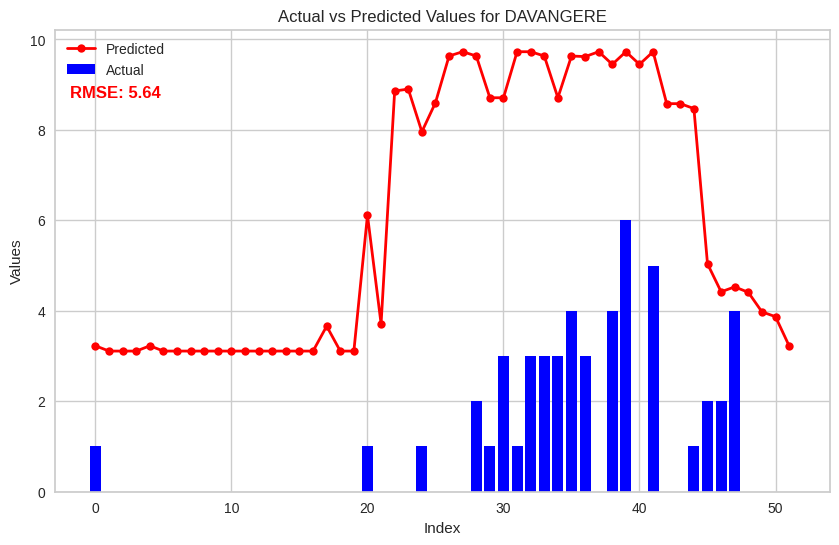

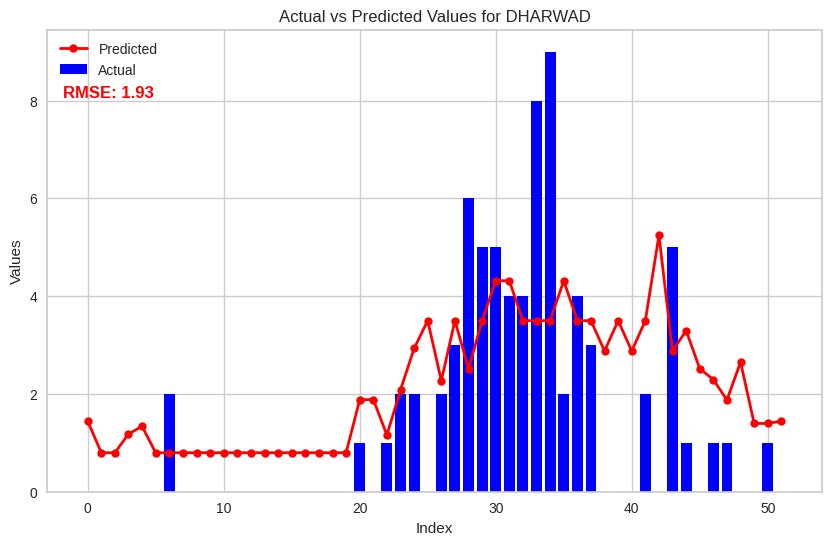

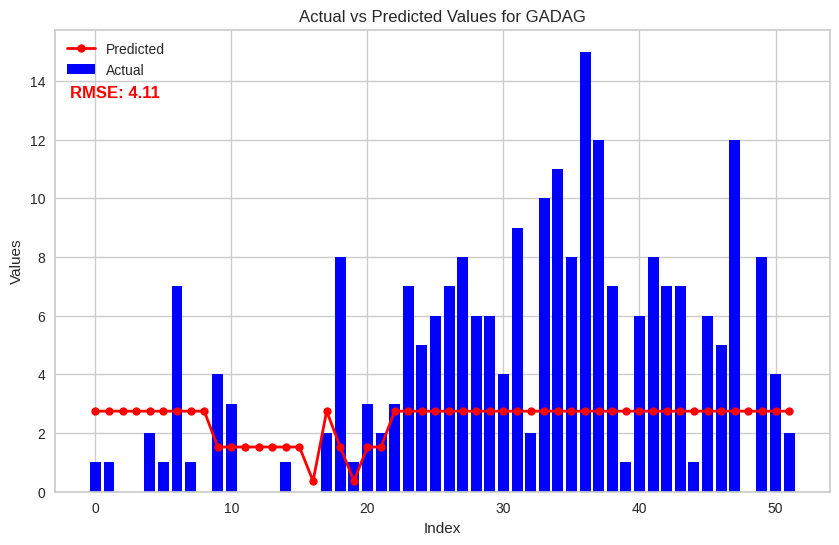

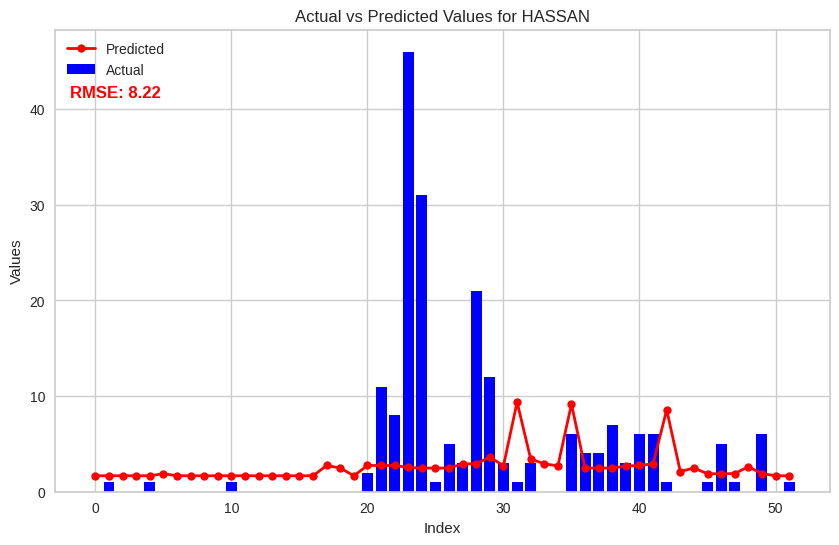

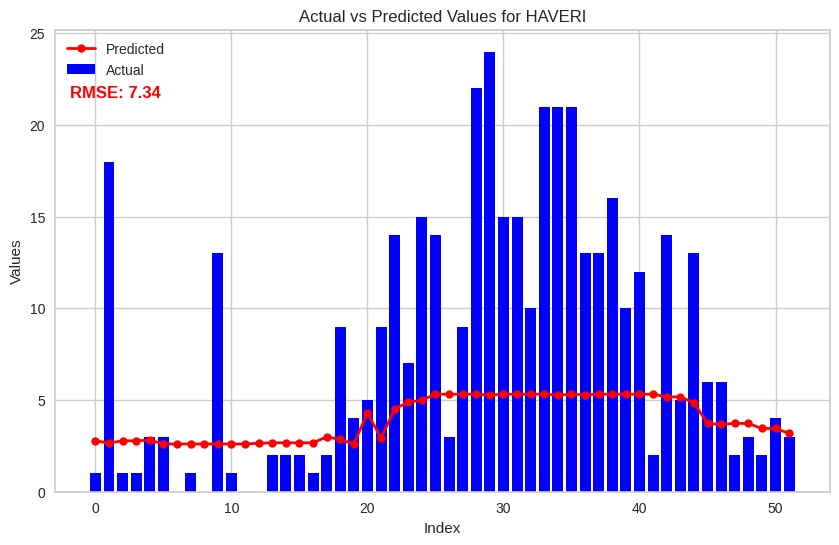

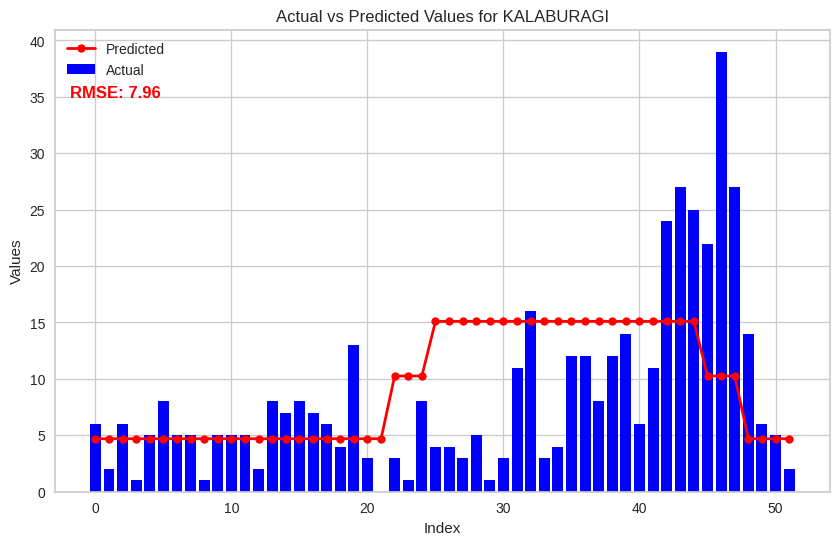

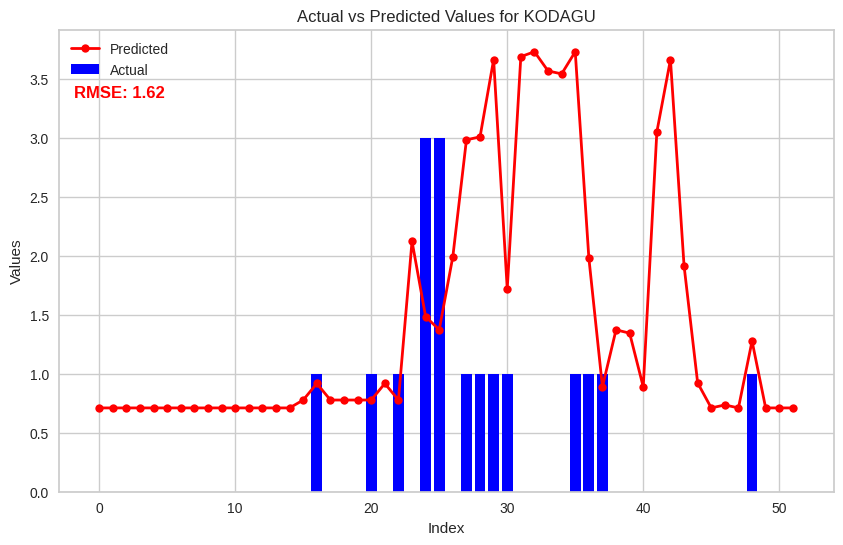

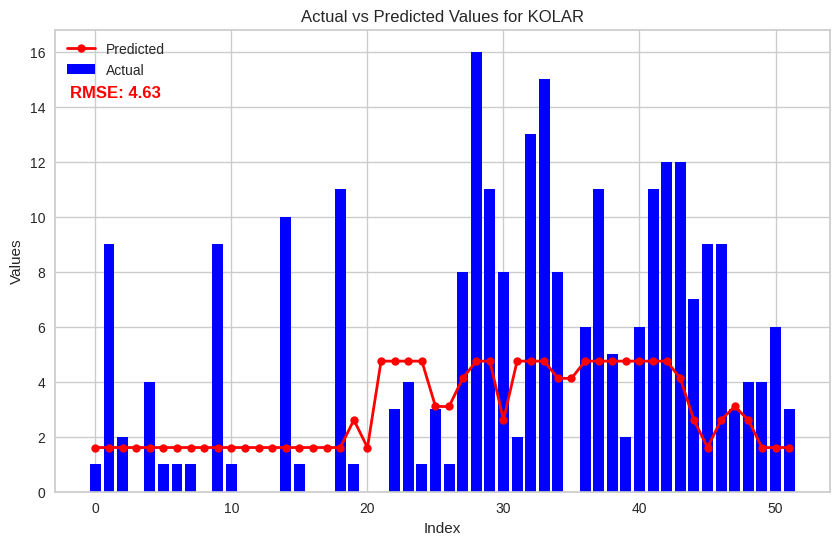

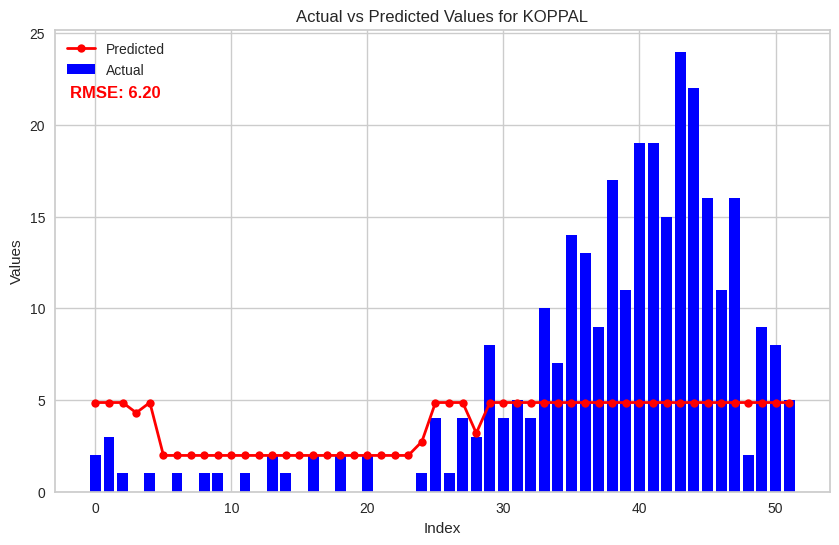

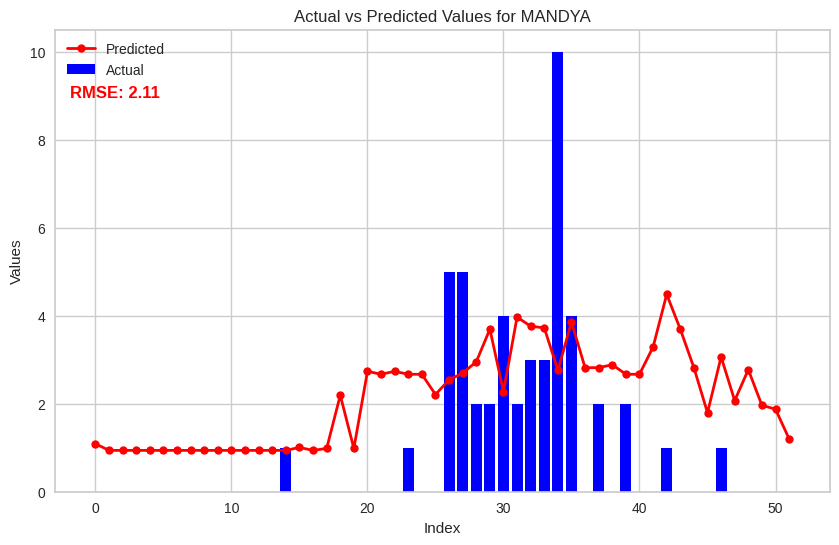

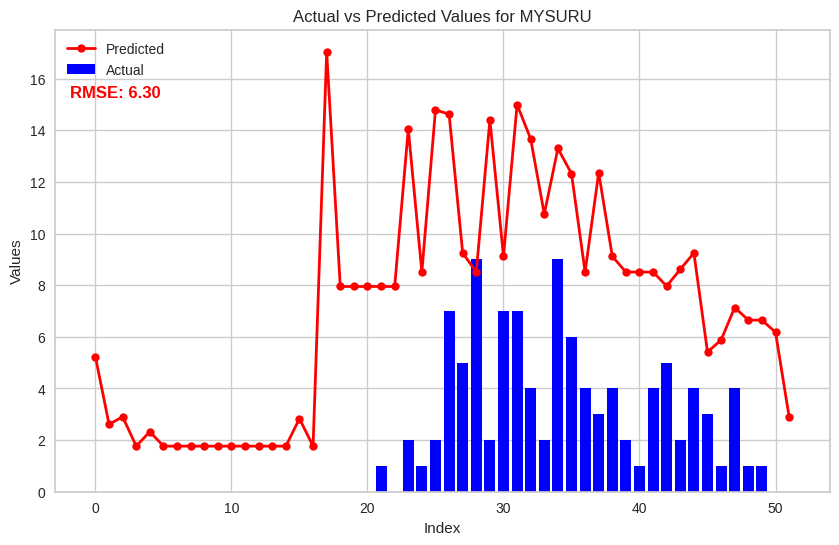

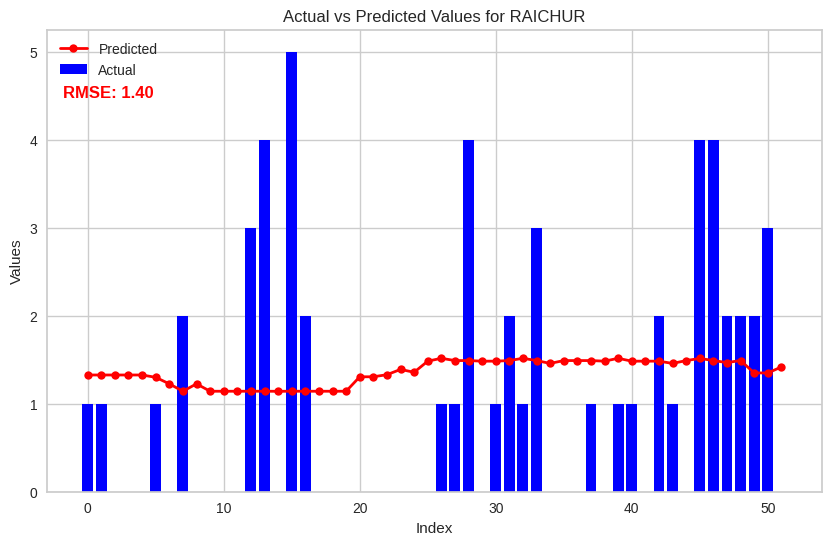

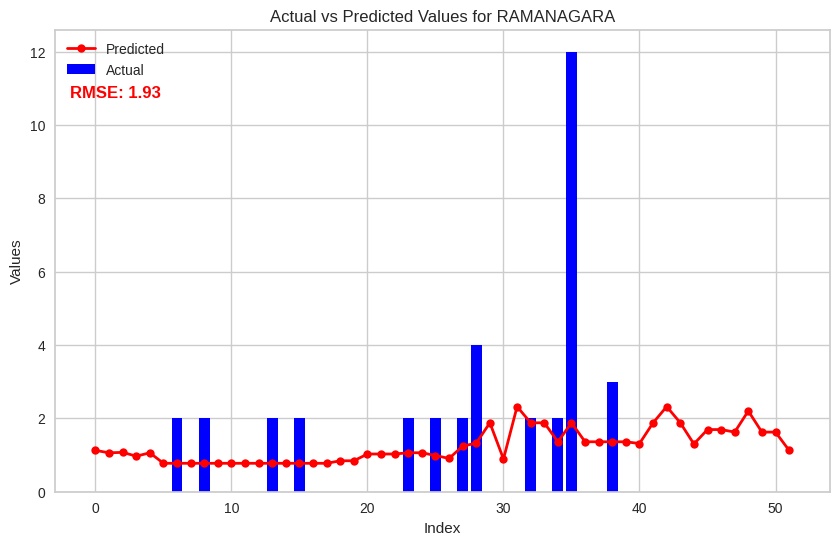

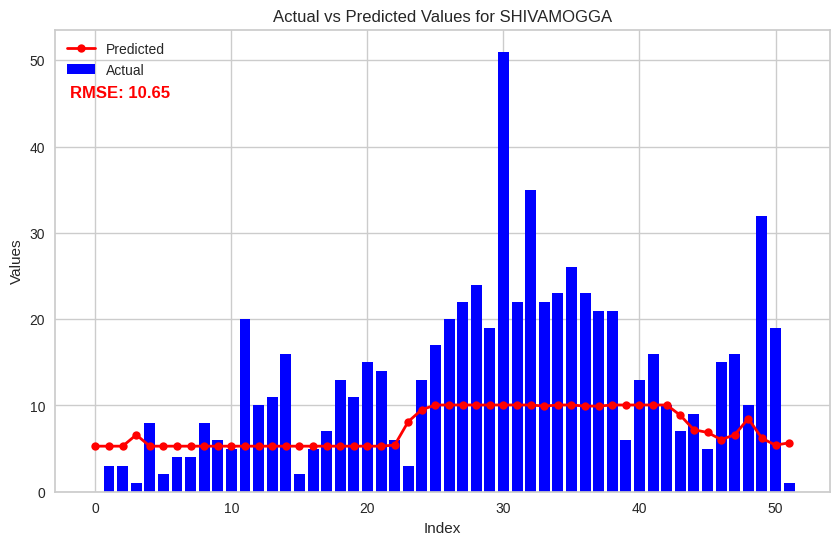

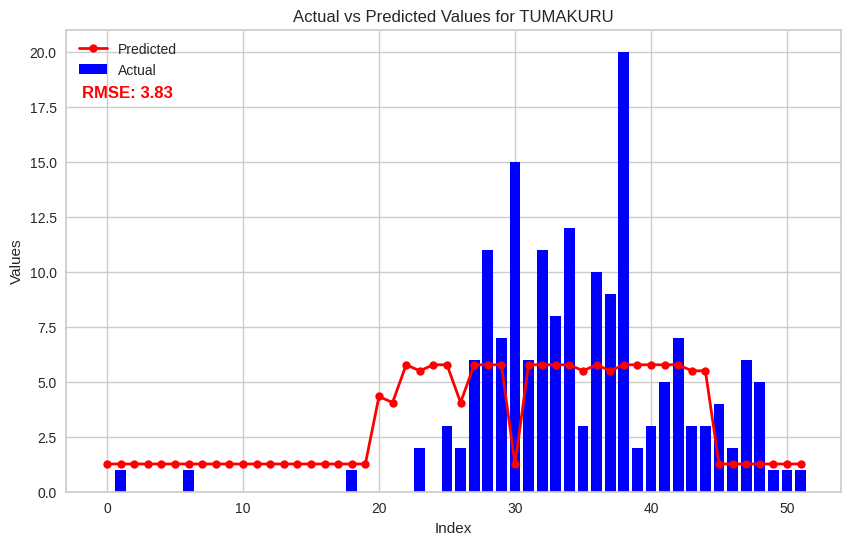

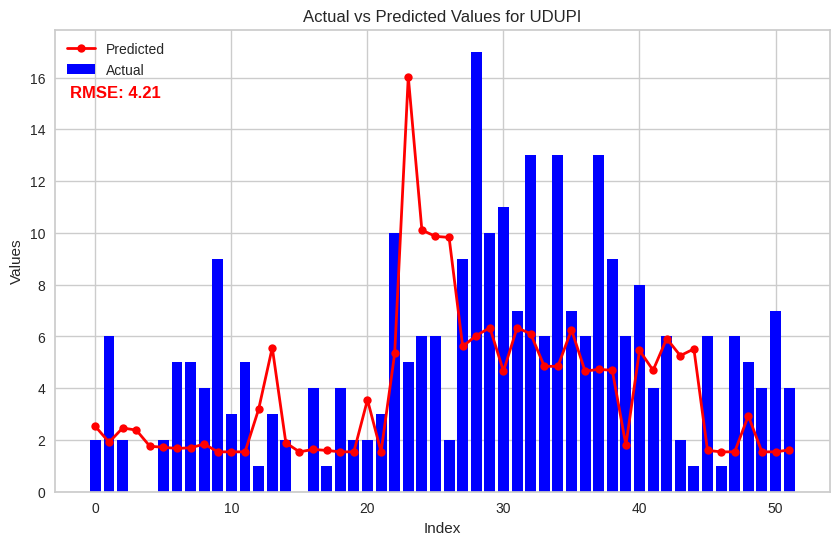

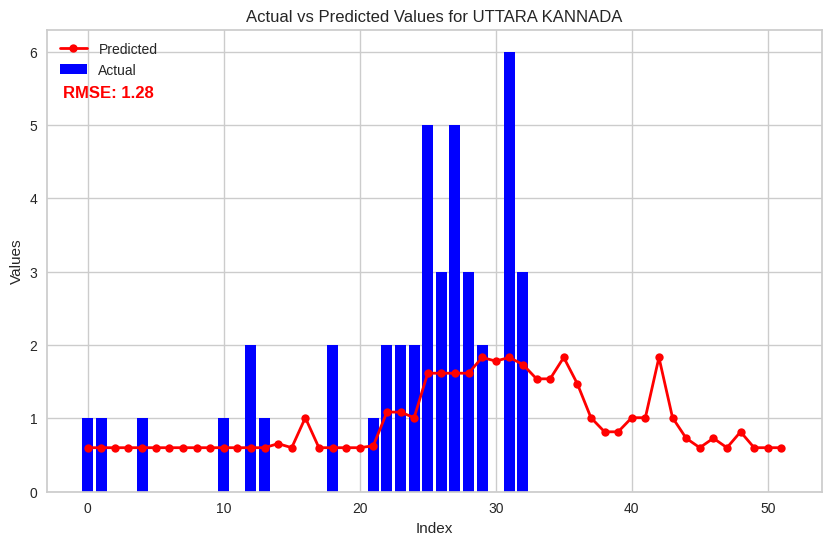

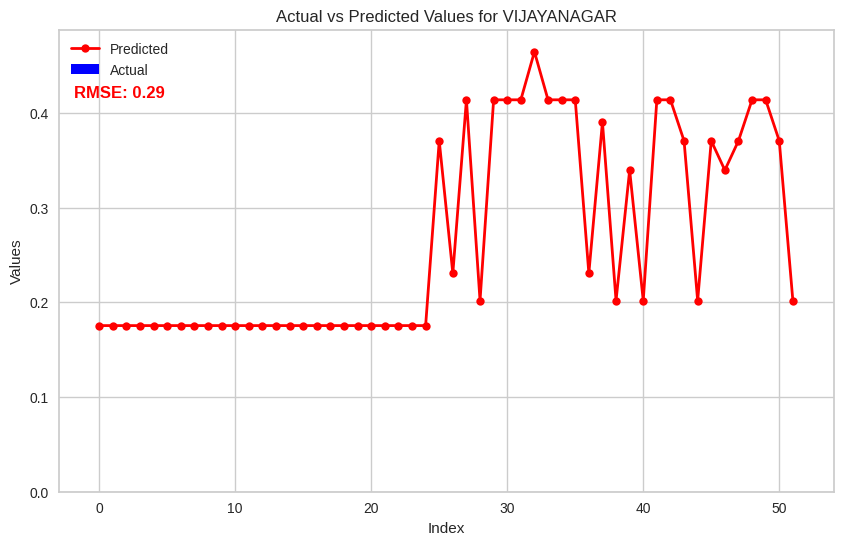

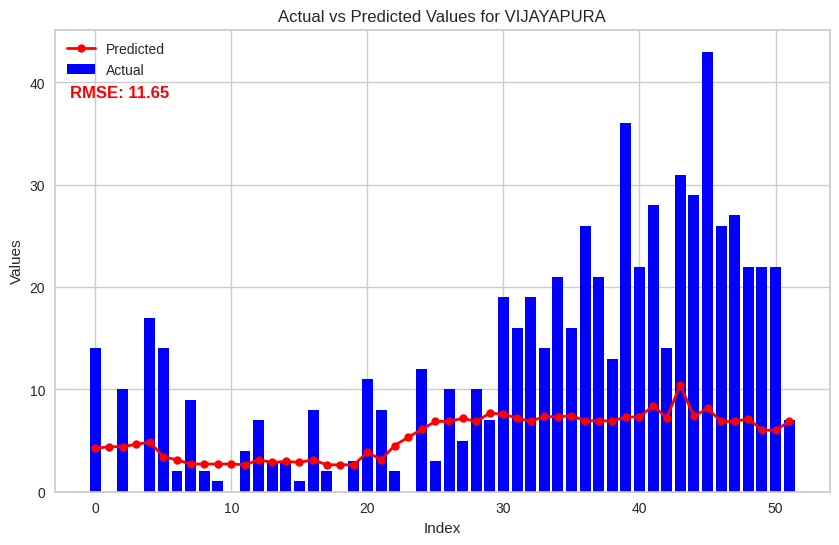

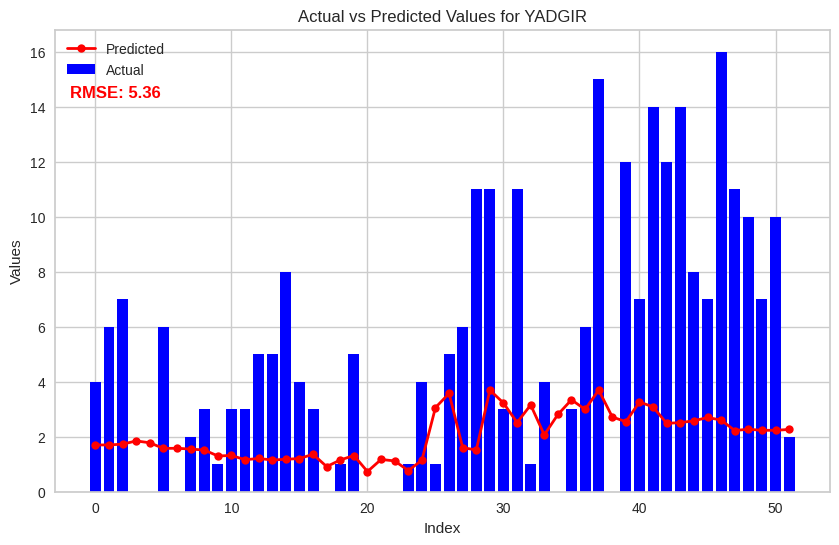

In [34]:
district_analysis = DistrictAnalysis("Karnataka_weather1980to2022.csv",2019)
df_2019 = district_analysis.analyze_districts()

Analyzing District: BAGALKOTE
Analyzing District: BALLARI
Analyzing District: BELAGAVI
Analyzing District: BENGALURU RURAL
Analyzing District: BENGALURU URBAN
Analyzing District: BIDAR
Analyzing District: CHAMARAJANAGARA
Analyzing District: CHIKKABALLAPURA
Analyzing District: CHIKKAMAGALURU
Analyzing District: CHITRADURGA
Analyzing District: DAKSHINA KANNADA
Analyzing District: DAVANGERE
Analyzing District: DHARWAD
Analyzing District: GADAG
Analyzing District: HASSAN
Analyzing District: HAVERI
Analyzing District: KALABURAGI
Analyzing District: KODAGU
Analyzing District: KOLAR
Analyzing District: KOPPAL
Analyzing District: MANDYA
Analyzing District: MYSURU
Analyzing District: RAICHUR
Analyzing District: RAMANAGARA
Analyzing District: SHIVAMOGGA
Analyzing District: TUMAKURU
Analyzing District: UDUPI
Analyzing District: UTTARA KANNADA
Analyzing District: VIJAYANAGAR
Analyzing District: VIJAYAPURA
Analyzing District: YADGIR


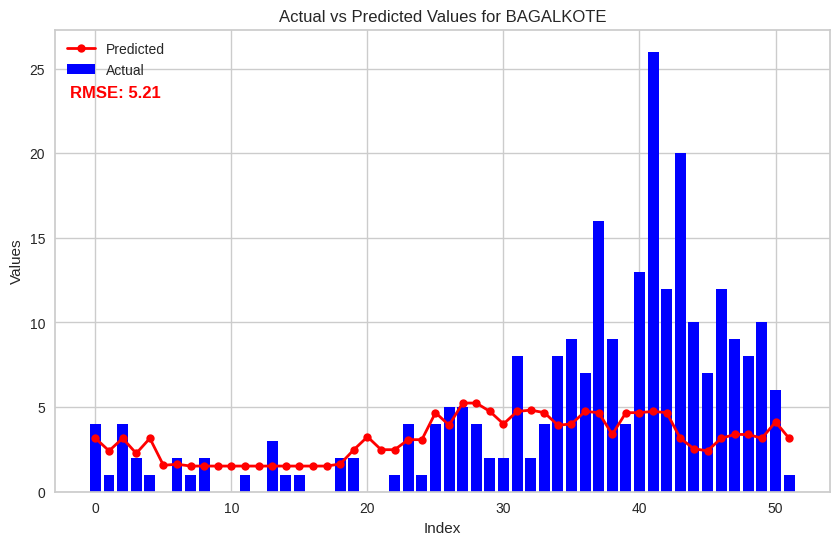

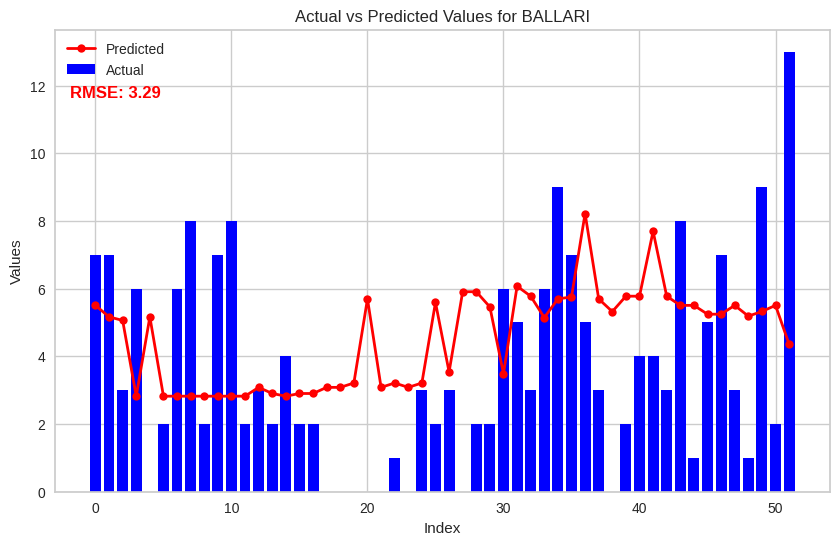

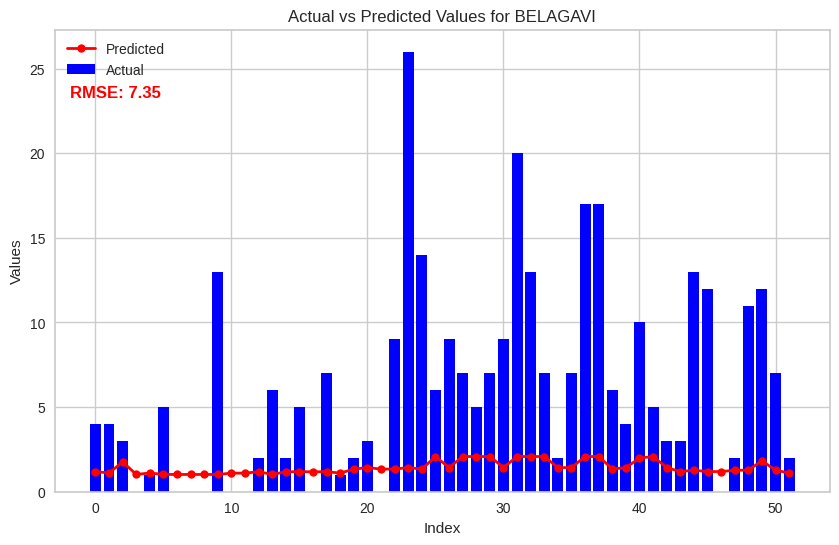

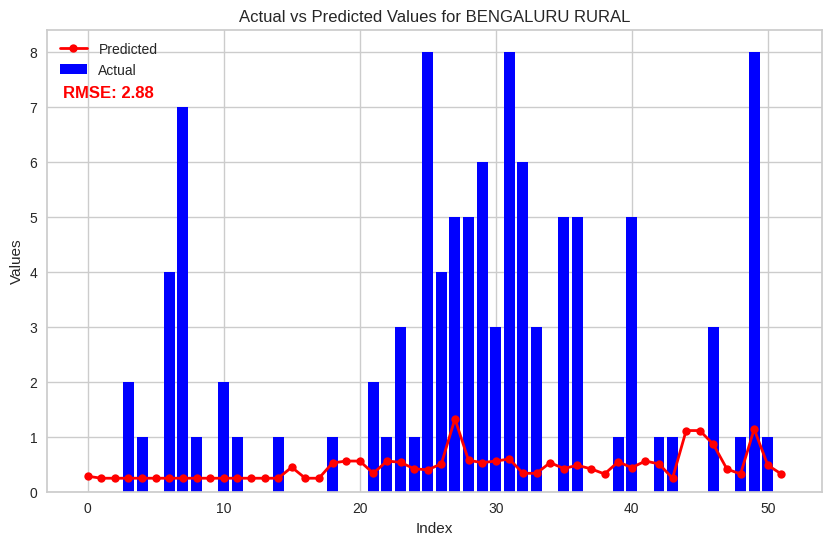

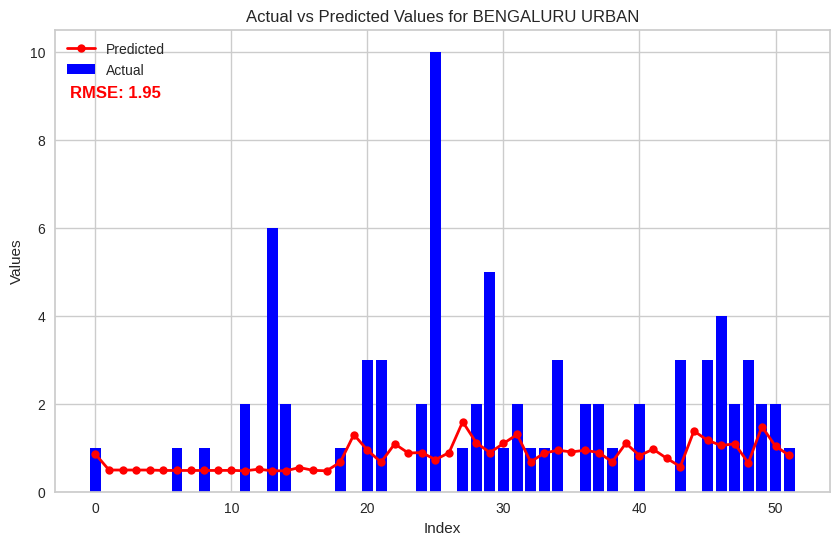

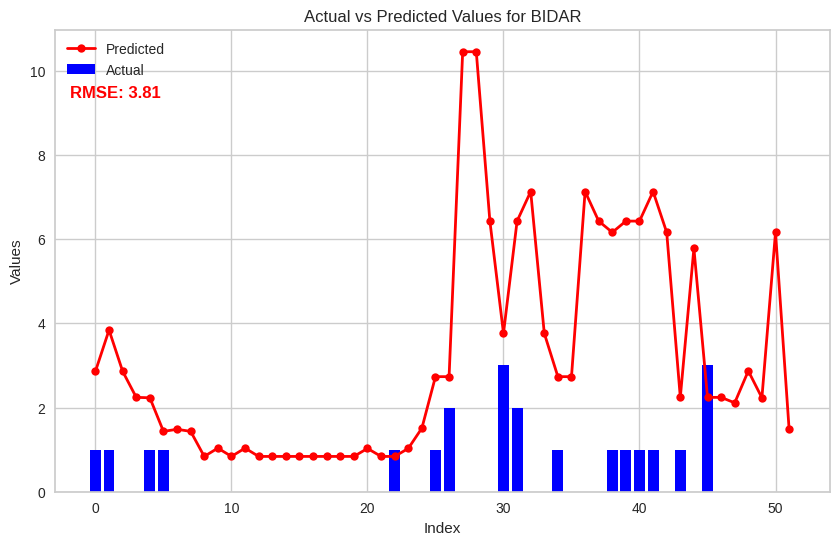

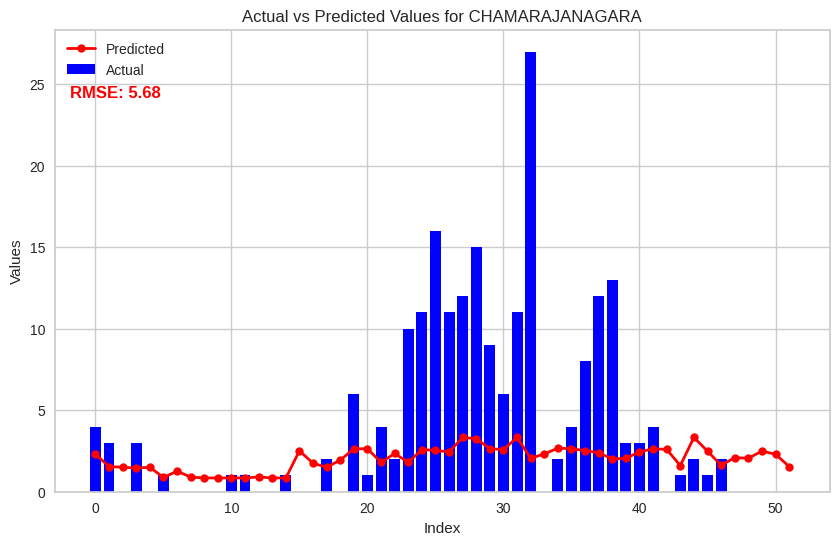

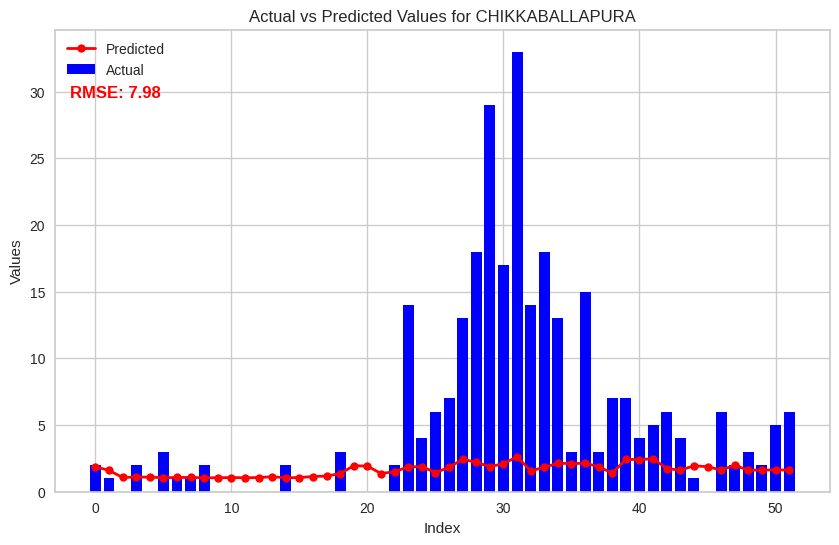

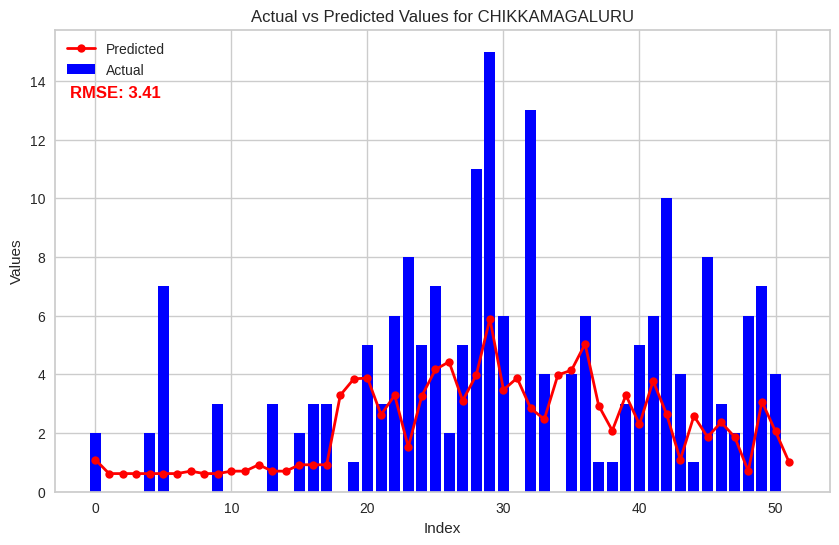

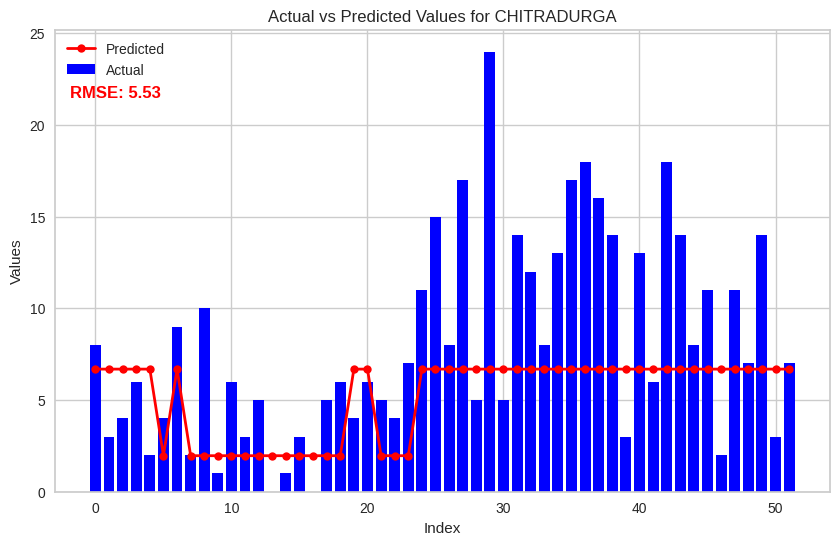

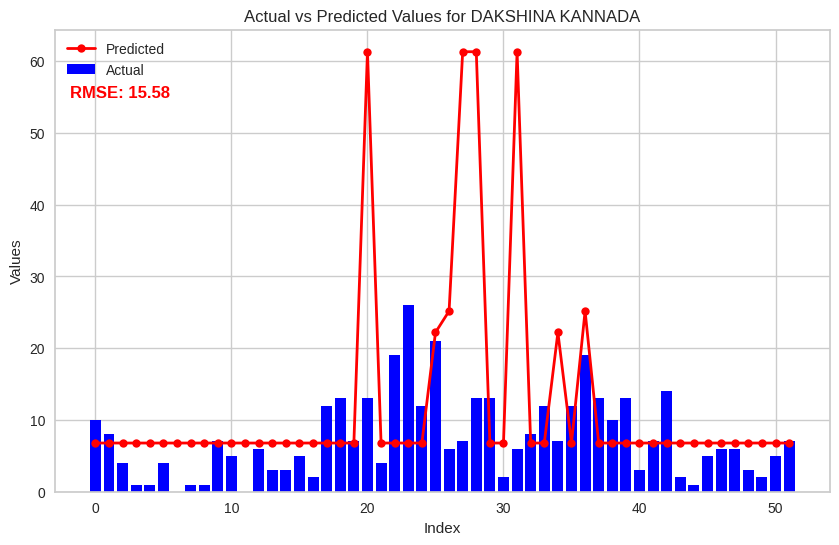

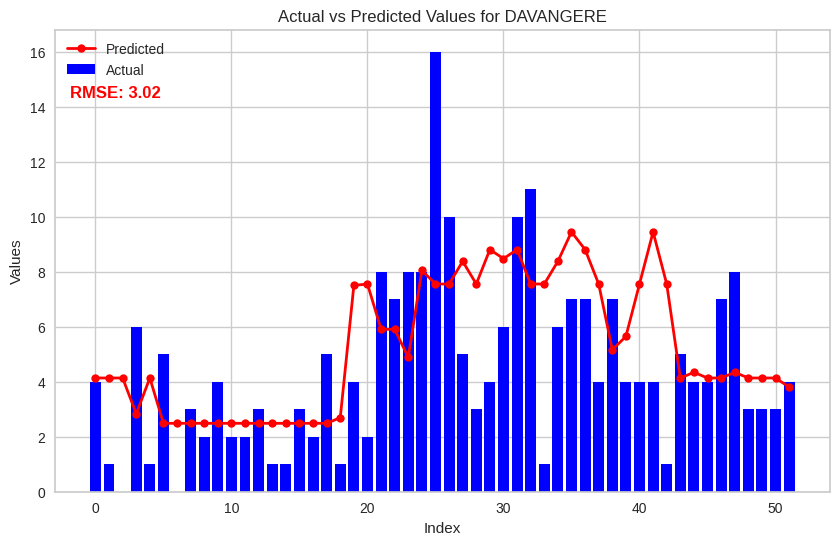

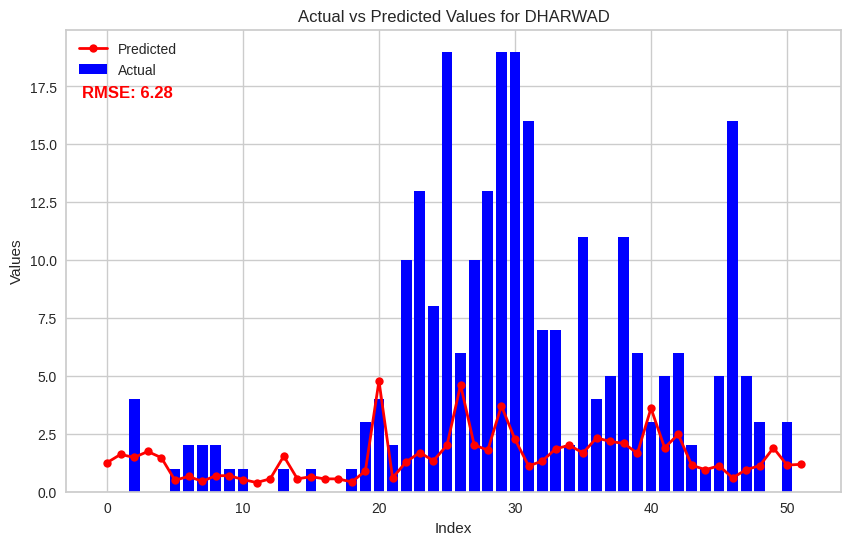

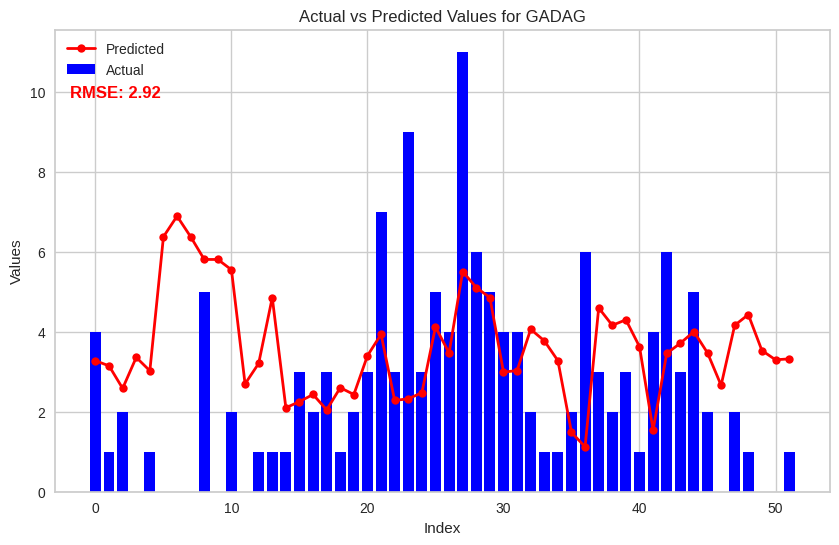

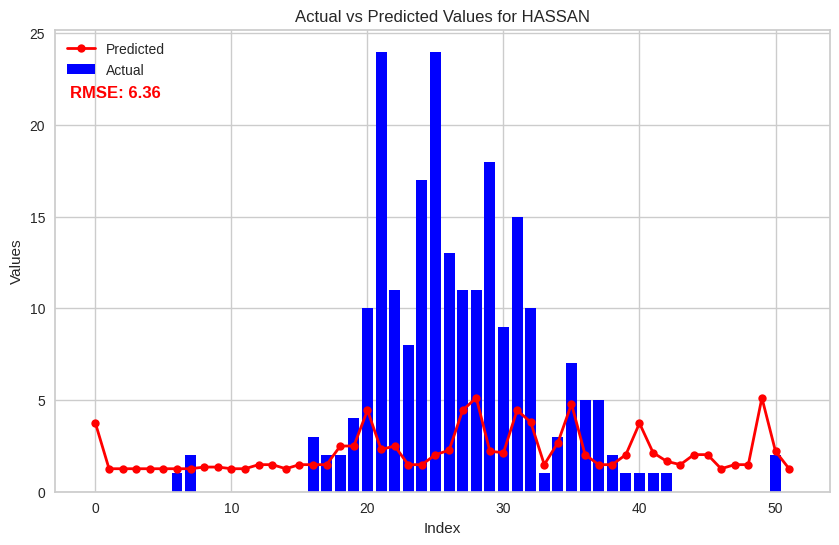

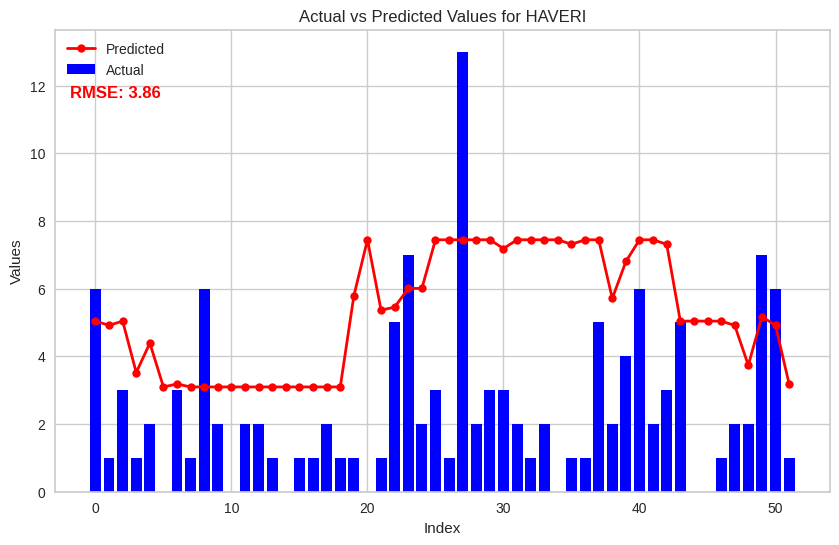

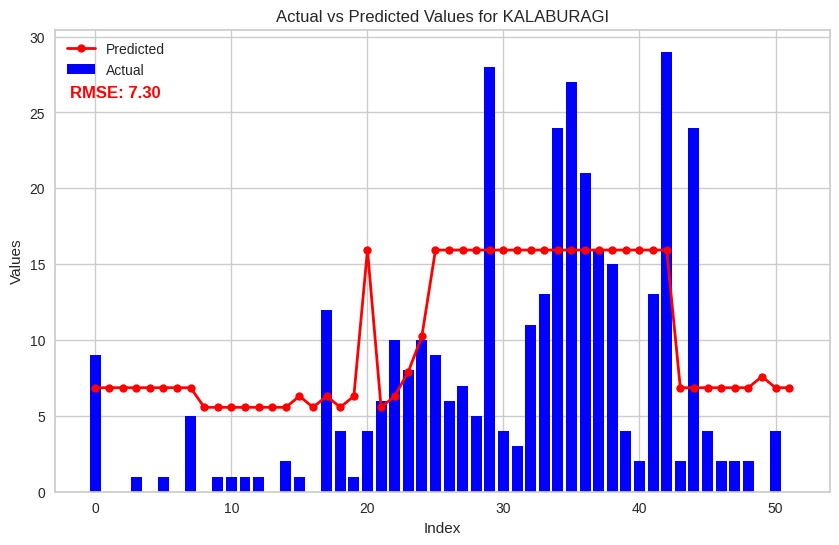

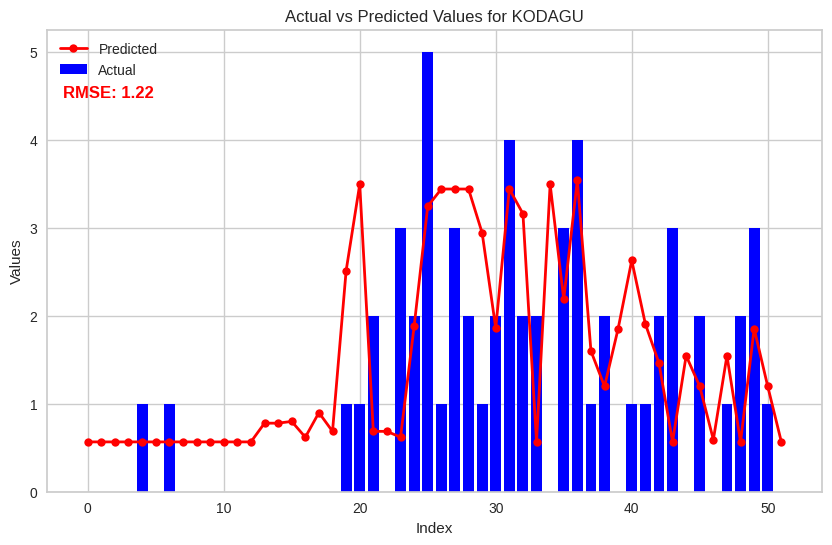

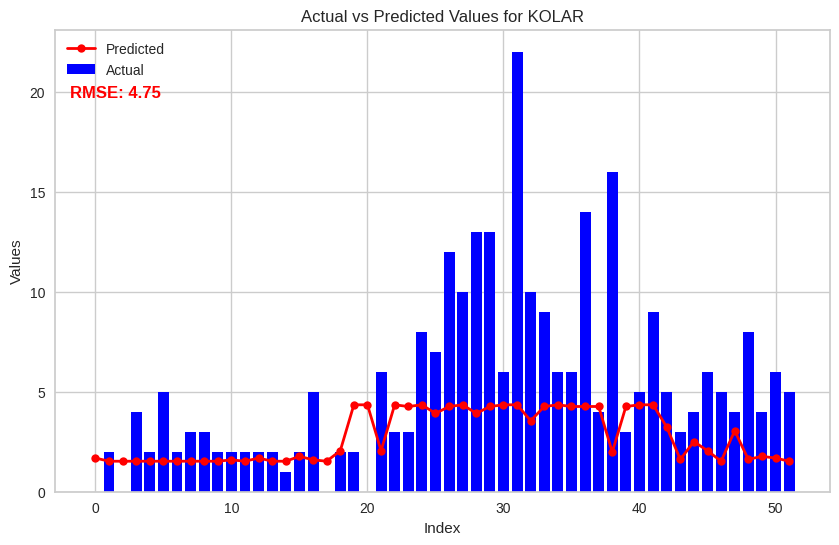

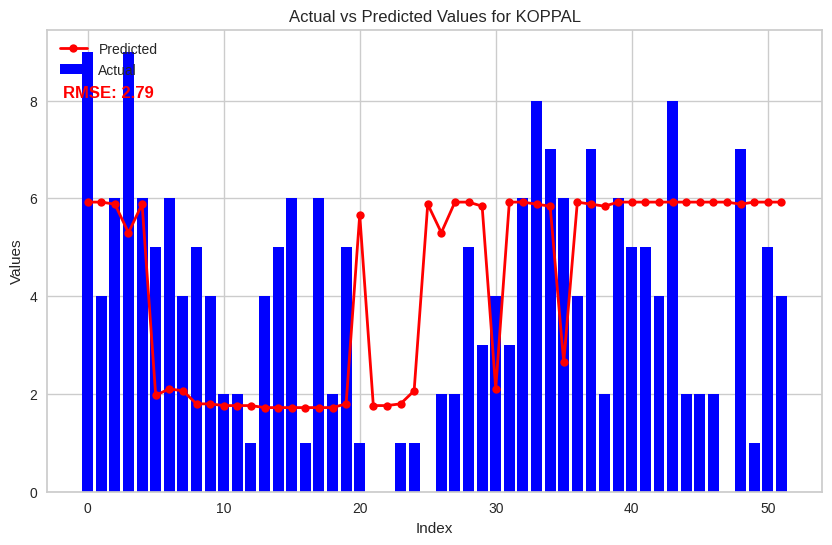

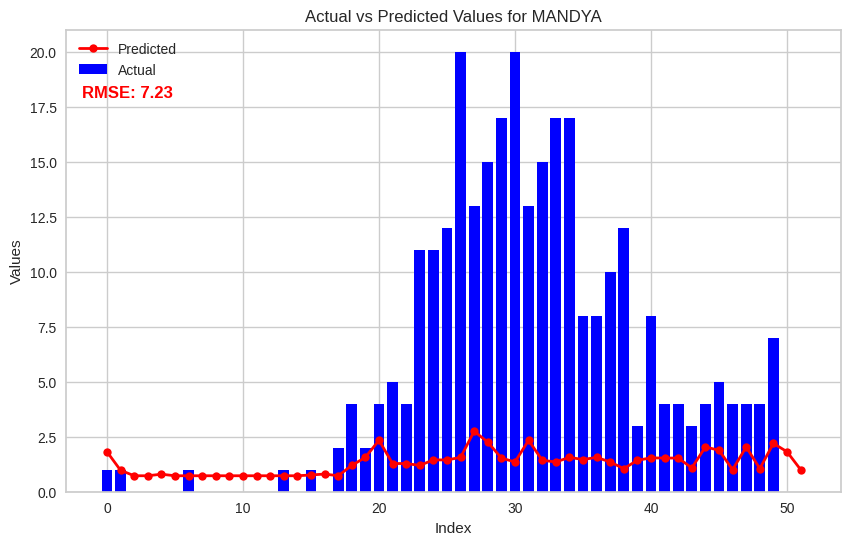

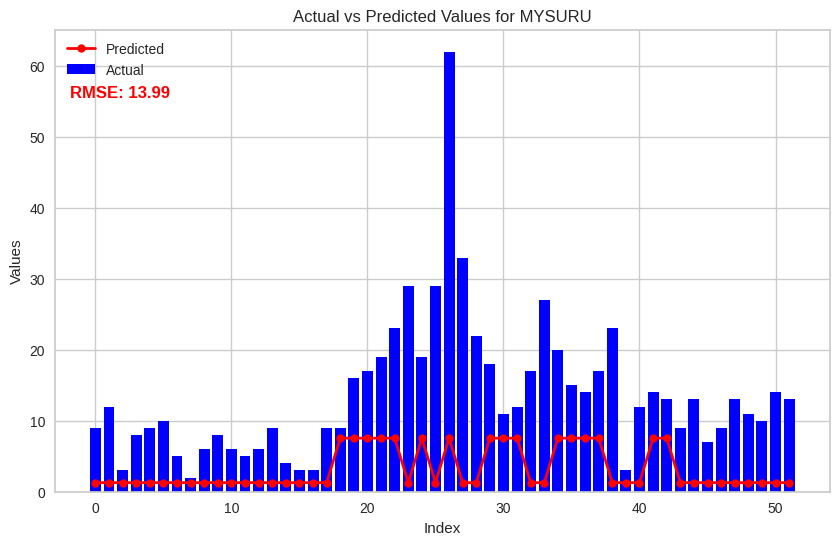

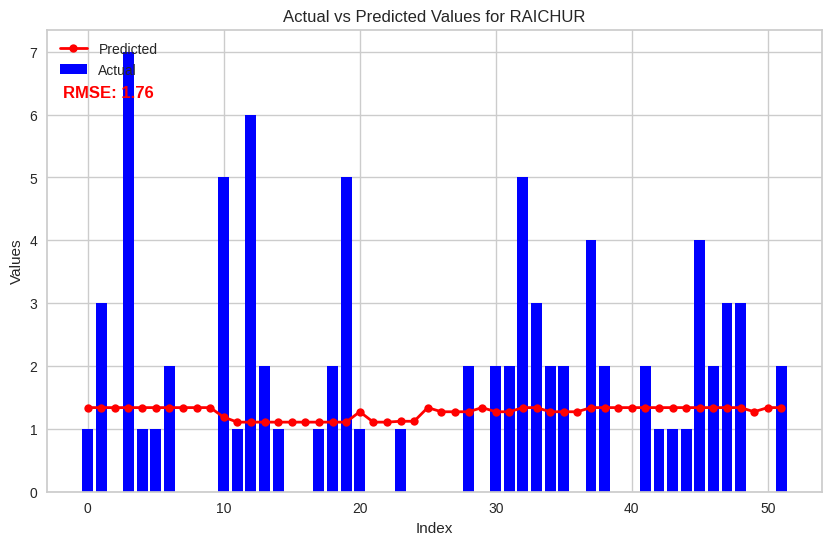

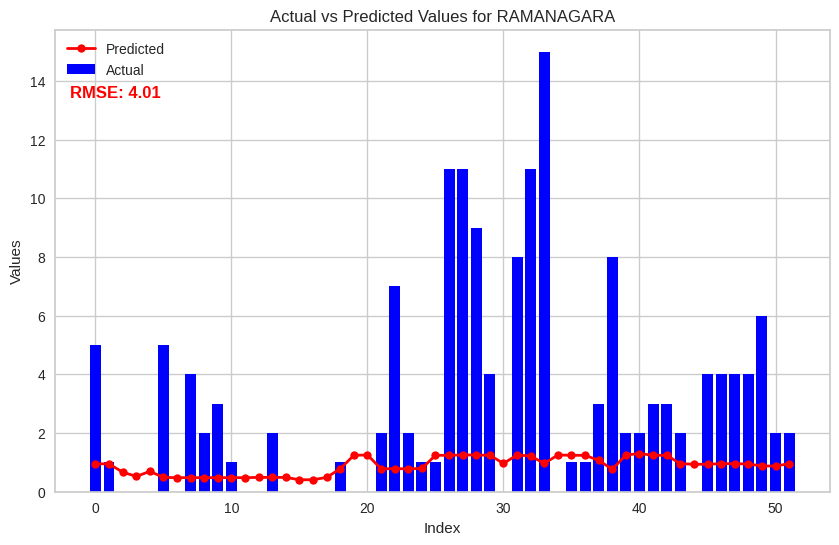

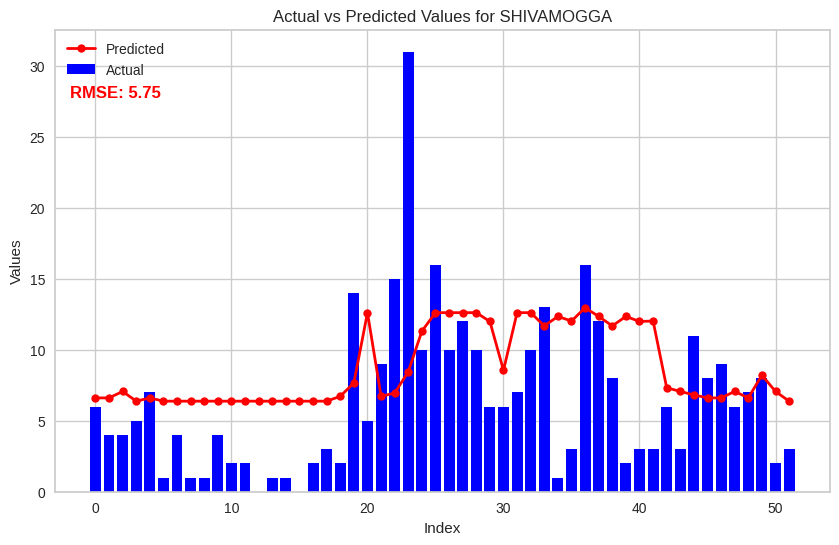

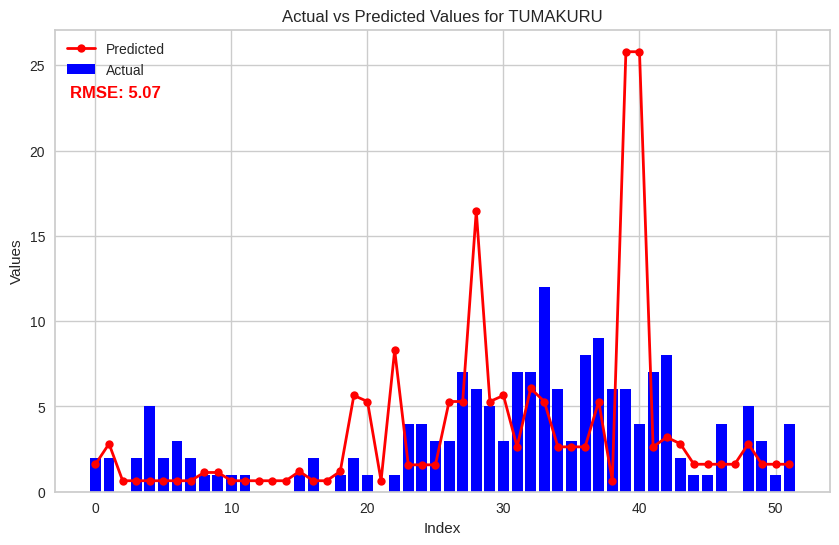

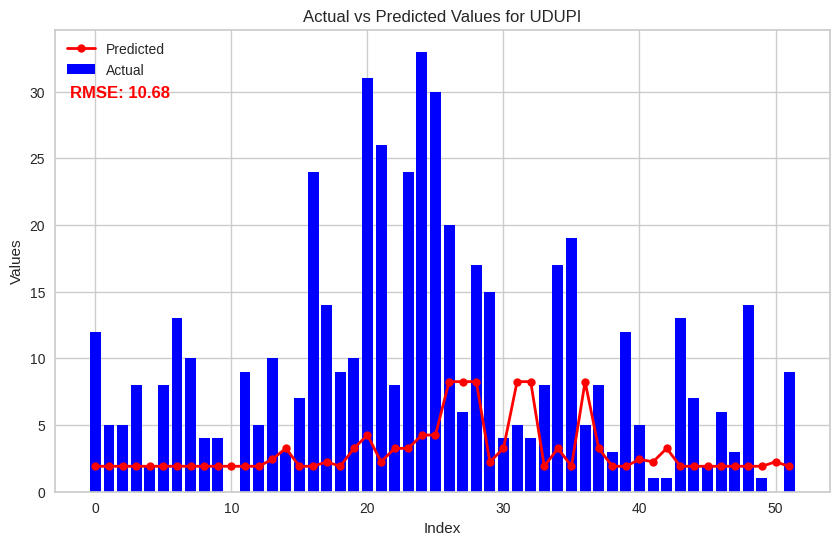

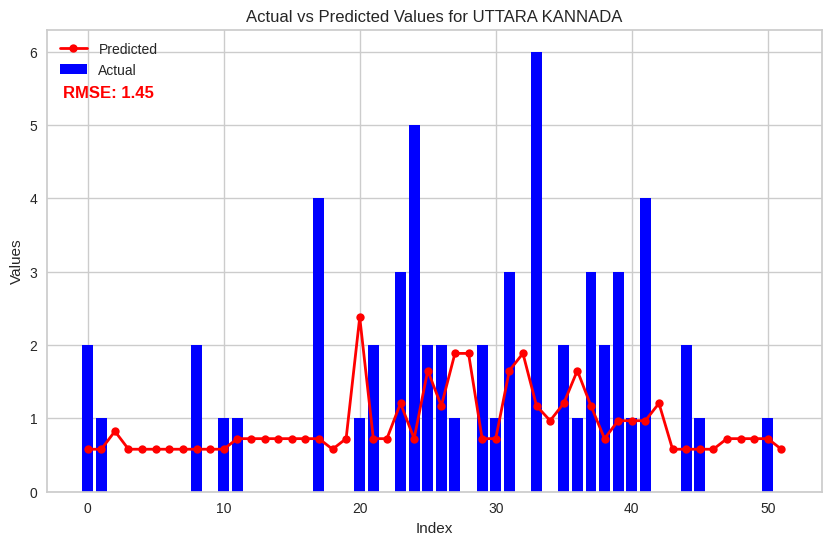

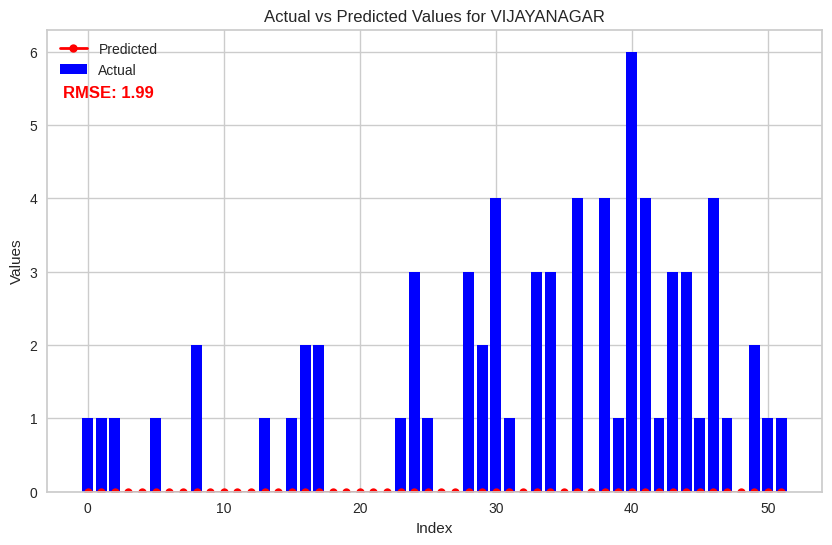

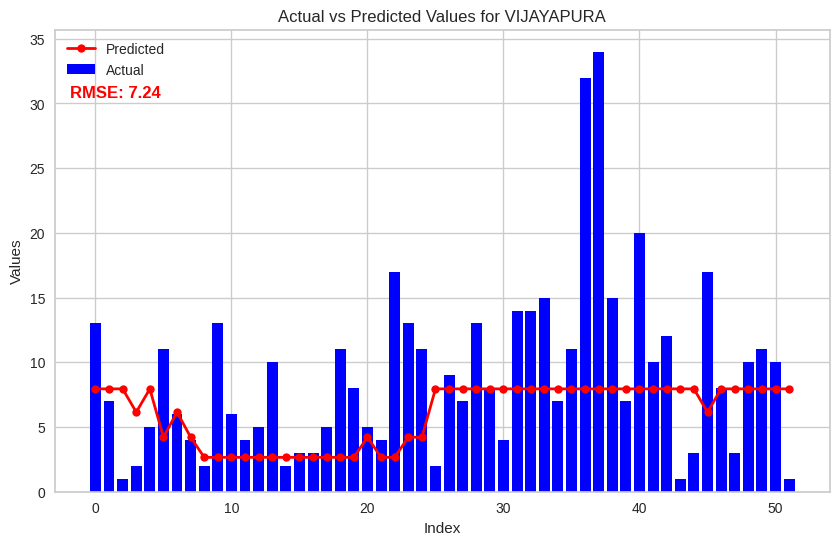

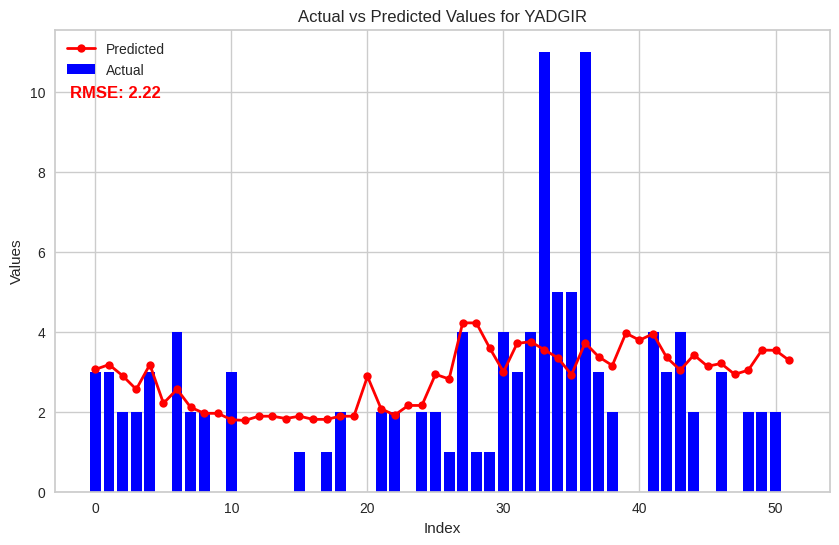

In [35]:
district_analysis = DistrictAnalysis("Karnataka_weather1980to2022.csv",2022)
df_2022 = district_analysis.analyze_districts()

In [36]:
from functools import reduce

# List of DataFrames to merge
dfs = [df_2017, df_2018, df_2019, df_2022]

# Function to merge two DataFrames on 'district' with suffixes
def merge_dfs(left, right):
    return pd.merge(left, right, on='district', suffixes=('', f"_{right.columns[-1][-4:]}"))

# Use reduce to iteratively merge all DataFrames
merged_df = reduce(merge_dfs, dfs)

merged_df

district  2017_rmse 2017_performance  2018_rmse 2018_performance  \
0          BAGALKOTE   6.616716              Bad   3.085941              Bad   
1            BALLARI  10.411563              Bad   4.201898              Bad   
2           BELAGAVI   2.052069              Bad   2.193551              Bad   
3    BENGALURU RURAL   0.793686             Good   0.754018             Good   
4    BENGALURU URBAN   1.092643             Good   1.052030             Good   
5              BIDAR   5.307823              Bad   4.040141              Bad   
6    CHAMARAJANAGARA   3.018138              Bad   2.346728              Bad   
7    CHIKKABALLAPURA   2.388495              Bad   3.608490              Bad   
8     CHIKKAMAGALURU   6.624506              Bad   2.235175              Bad   
9        CHITRADURGA   8.188596              Bad   6.283351              Bad   
10  DAKSHINA KANNADA   7.992087              Bad  13.337178              Bad   
11         DAVANGERE  20.362137              Bad   4.494465              Bad   
12           DHARWAD   2.592432              Bad   2.595489              Bad   
13             GADAG   3.498164              Bad   3.075649              Bad   
14            HASSAN   3.743206              Bad   8.292012              Bad   
15            HAVERI   6.997480              Bad   2.927817              Bad   
16        KALABURAGI  28.780813              Bad  19.393205              Bad   
17            KODAGU   8.677875              Bad   1.539838             Good   
18             KOLAR   7.878676              Bad   3.587576              Bad   
19            KOPPAL   3.989389              Bad   3.964787              Bad   
20            MANDYA   2.701954              Bad   2.730638              Bad   
21            MYSURU  24.045005              Bad   6.318190              Bad   
22           RAICHUR   3.400755              Bad   1.926970             Good   
23        RAMANAGARA   8.396047              Bad   1.344133             Good   
24        SHIVAMOGGA  10.580864              Bad   5.321833              Bad   
25          TUMAKURU  15.717036              Bad   4.931971              Bad   
26             UDUPI   5.095411              Bad   5.886339              Bad   
27    UTTARA KANNADA   1.176597             Good   2.041811              Bad   
28       VIJAYANAGAR   0.275199             Good   0.248773             Good   
29        VIJAYAPURA   5.427360              Bad   6.207022              Bad   
30            YADGIR   2.370097              Bad   1.991982             Good   

    2019_rmse 2019_performance  2022_rmse 2022_performance  
0    7.070750              Bad   5.211089              Bad  
1    4.704183              Bad   3.287056              Bad  
2    2.163861              Bad   7.351535              Bad  
3    1.285322             Good   2.880321              Bad  
4    3.789293              Bad   1.950111             Good  
5   10.361470              Bad   3.811301              Bad  
6   10.708050              Bad   5.677725              Bad  
7    5.704618              Bad   7.982812              Bad  
8    5.001006              Bad   3.407294              Bad  
9    6.850287              Bad   5.530633              Bad  
10  48.427648              Bad  15.580089              Bad  
11   5.639510              Bad   3.024162              Bad  
12   1.934692             Good   6.284032              Bad  
13   4.113495              Bad   2.920380              Bad  
14   8.215847              Bad   6.359973              Bad  
15   7.344649              Bad   3.856991              Bad  
16   7.959484              Bad   7.303760              Bad  
17   1.618236             Good   1.218550             Good  
18   4.627846              Bad   4.748106              Bad  
19   6.202056              Bad   2.786493              Bad  
20   2.108011              Bad   7.228327              Bad  
21   6.296205              Bad  13.991822              Bad  
22   1.396923             Good   1.755793       

In [37]:
merged_df = merged_df.round(2)
merged_df

district  2017_rmse 2017_performance  2018_rmse 2018_performance  \
0          BAGALKOTE       6.62              Bad       3.09              Bad   
1            BALLARI      10.41              Bad       4.20              Bad   
2           BELAGAVI       2.05              Bad       2.19              Bad   
3    BENGALURU RURAL       0.79             Good       0.75             Good   
4    BENGALURU URBAN       1.09             Good       1.05             Good   
5              BIDAR       5.31              Bad       4.04              Bad   
6    CHAMARAJANAGARA       3.02              Bad       2.35              Bad   
7    CHIKKABALLAPURA       2.39              Bad       3.61              Bad   
8     CHIKKAMAGALURU       6.62              Bad       2.24              Bad   
9        CHITRADURGA       8.19              Bad       6.28              Bad   
10  DAKSHINA KANNADA       7.99              Bad      13.34              Bad   
11         DAVANGERE      20.36              Bad       4.49              Bad   
12           DHARWAD       2.59              Bad       2.60              Bad   
13             GADAG       3.50              Bad       3.08              Bad   
14            HASSAN       3.74              Bad       8.29              Bad   
15            HAVERI       7.00              Bad       2.93              Bad   
16        KALABURAGI      28.78              Bad      19.39              Bad   
17            KODAGU       8.68              Bad       1.54             Good   
18             KOLAR       7.88              Bad       3.59              Bad   
19            KOPPAL       3.99              Bad       3.96              Bad   
20            MANDYA       2.70              Bad       2.73              Bad   
21            MYSURU      24.05              Bad       6.32              Bad   
22           RAICHUR       3.40              Bad       1.93             Good   
23        RAMANAGARA       8.40              Bad       1.34             Good   
24        SHIVAMOGGA      10.58              Bad       5.32              Bad   
25          TUMAKURU      15.72              Bad       4.93              Bad   
26             UDUPI       5.10              Bad       5.89              Bad   
27    UTTARA KANNADA       1.18             Good       2.04              Bad   
28       VIJAYANAGAR       0.28             Good       0.25             Good   
29        VIJAYAPURA       5.43              Bad       6.21              Bad   
30            YADGIR       2.37              Bad       1.99             Good   

    2019_rmse 2019_performance  2022_rmse 2022_performance  
0        7.07              Bad       5.21              Bad  
1        4.70              Bad       3.29              Bad  
2        2.16              Bad       7.35              Bad  
3        1.29             Good       2.88              Bad  
4        3.79              Bad       1.95             Good  
5       10.36              Bad       3.81              Bad  
6       10.71              Bad       5.68              Bad  
7        5.70              Bad       7.98              Bad  
8        5.00              Bad       3.41              Bad  
9        6.85              Bad       5.53              Bad  
10      48.43              Bad      15.58              Bad  
11       5.64              Bad       3.02              Bad  
12       1.93             Good       6.28              Bad  
13       4.11              Bad       2.92              Bad  
14       8.22              Bad       6.36              Bad  
15       7.34              Bad       3.86              Bad  
16       7.96              Bad       7.30              Bad  
17       1.62             Good       1.22             Good  
18       4.63              Bad       4.75              Bad  
19       6.20              Bad       2.79              Bad  
20       2.11              Bad       7.23              Bad  
21       6.30              Bad      13.99              Bad  
22       1.40             Good       1.76       

In [38]:
merged_df.to_csv('Random_forest_performance.csv', index=False)

In [39]:
df = pd.read_csv("Random_forest_performance.csv")
df

district  2017_rmse 2017_performance  2018_rmse 2018_performance  \
0          BAGALKOTE       6.62              Bad       3.09              Bad   
1            BALLARI      10.41              Bad       4.20              Bad   
2           BELAGAVI       2.05              Bad       2.19              Bad   
3    BENGALURU RURAL       0.79             Good       0.75             Good   
4    BENGALURU URBAN       1.09             Good       1.05             Good   
5              BIDAR       5.31              Bad       4.04              Bad   
6    CHAMARAJANAGARA       3.02              Bad       2.35              Bad   
7    CHIKKABALLAPURA       2.39              Bad       3.61              Bad   
8     CHIKKAMAGALURU       6.62              Bad       2.24              Bad   
9        CHITRADURGA       8.19              Bad       6.28              Bad   
10  DAKSHINA KANNADA       7.99              Bad      13.34              Bad   
11         DAVANGERE      20.36              Bad       4.49              Bad   
12           DHARWAD       2.59              Bad       2.60              Bad   
13             GADAG       3.50              Bad       3.08              Bad   
14            HASSAN       3.74              Bad       8.29              Bad   
15            HAVERI       7.00              Bad       2.93              Bad   
16        KALABURAGI      28.78              Bad      19.39              Bad   
17            KODAGU       8.68              Bad       1.54             Good   
18             KOLAR       7.88              Bad       3.59              Bad   
19            KOPPAL       3.99              Bad       3.96              Bad   
20            MANDYA       2.70              Bad       2.73              Bad   
21            MYSURU      24.05              Bad       6.32              Bad   
22           RAICHUR       3.40              Bad       1.93             Good   
23        RAMANAGARA       8.40              Bad       1.34             Good   
24        SHIVAMOGGA      10.58              Bad       5.32              Bad   
25          TUMAKURU      15.72              Bad       4.93              Bad   
26             UDUPI       5.10              Bad       5.89              Bad   
27    UTTARA KANNADA       1.18             Good       2.04              Bad   
28       VIJAYANAGAR       0.28             Good       0.25             Good   
29        VIJAYAPURA       5.43              Bad       6.21              Bad   
30            YADGIR       2.37              Bad       1.99             Good   

    2019_rmse 2019_performance  2022_rmse 2022_performance  
0        7.07              Bad       5.21              Bad  
1        4.70              Bad       3.29              Bad  
2        2.16              Bad       7.35              Bad  
3        1.29             Good       2.88              Bad  
4        3.79              Bad       1.95             Good  
5       10.36              Bad       3.81              Bad  
6       10.71              Bad       5.68              Bad  
7        5.70              Bad       7.98              Bad  
8        5.00              Bad       3.41              Bad  
9        6.85              Bad       5.53              Bad  
10      48.43              Bad      15.58              Bad  
11       5.64              Bad       3.02              Bad  
12       1.93             Good       6.28              Bad  
13       4.11              Bad       2.92              Bad  
14       8.22              Bad       6.36              Bad  
15       7.34              Bad       3.86              Bad  
16       7.96              Bad       7.30              Bad  
17       1.62             Good       1.22             Good  
18       4.63              Bad       4.75              Bad  
19       6.20              Bad       2.79              Bad  
20       2.11              Bad       7.23              Bad  
21       6.30              Bad      13.99              Bad  
22       1.40             Good       1.76       